In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pickle

font = {
        'weight' : 'bold',
        'size'   : 40}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [9, 5.5]
plt.rcParams['figure.dpi'] = 300
plt.rc('font', **font)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

In [2]:
# For E-BASS experiment
# N_TASKS = 400
# N_ARMS = 11
# OPT_SIZE = 2 # >1
# HORIZON = 600

N_TASKS = 500
N_ARMS = 30
OPT_SIZE = 10 # >1
HORIZON = 4500 #160 for small \tau experiment
N_EXPS = 5 #No. of repeat experiments

GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD)
kwargs = {
          'gap_constrain':gap, #or None
          'is_adversarial': True,
          'skip_list': ["G_BASS_FC", "EE", "E_BASS"],
          'timeout': 45, # maximum duration for each experiment. Unit = minute. -1 = unlimited
          'quiet': True,
          'linewidth': 7, # plotting parameter
          'plot_legend': False,
          'OG_scale': 1,
          'is_non_oblivious': False,
         }

if kwargs['is_adversarial']:
    setting = "Adversarial"
else:
    setting = "Stochastic"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')
utils.verify_params(N_TASKS, N_ARMS, HORIZON, OPT_SIZE, **kwargs)

GAP_THRESHOLD = 0.20354537738830608, actual gap = 0.20354537738830608
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.


## Regret vs Number of tasks

In [ ]:
# task_list = np.arange(100, 501, 100)
task_list = np.arange(500, 2501, 500)
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, N_ARMS, OPT_SIZE, HORIZON, task_list, **kwargs)
pickle.dump(regret_dict, open("results/tasks.p", "wb"))
pass

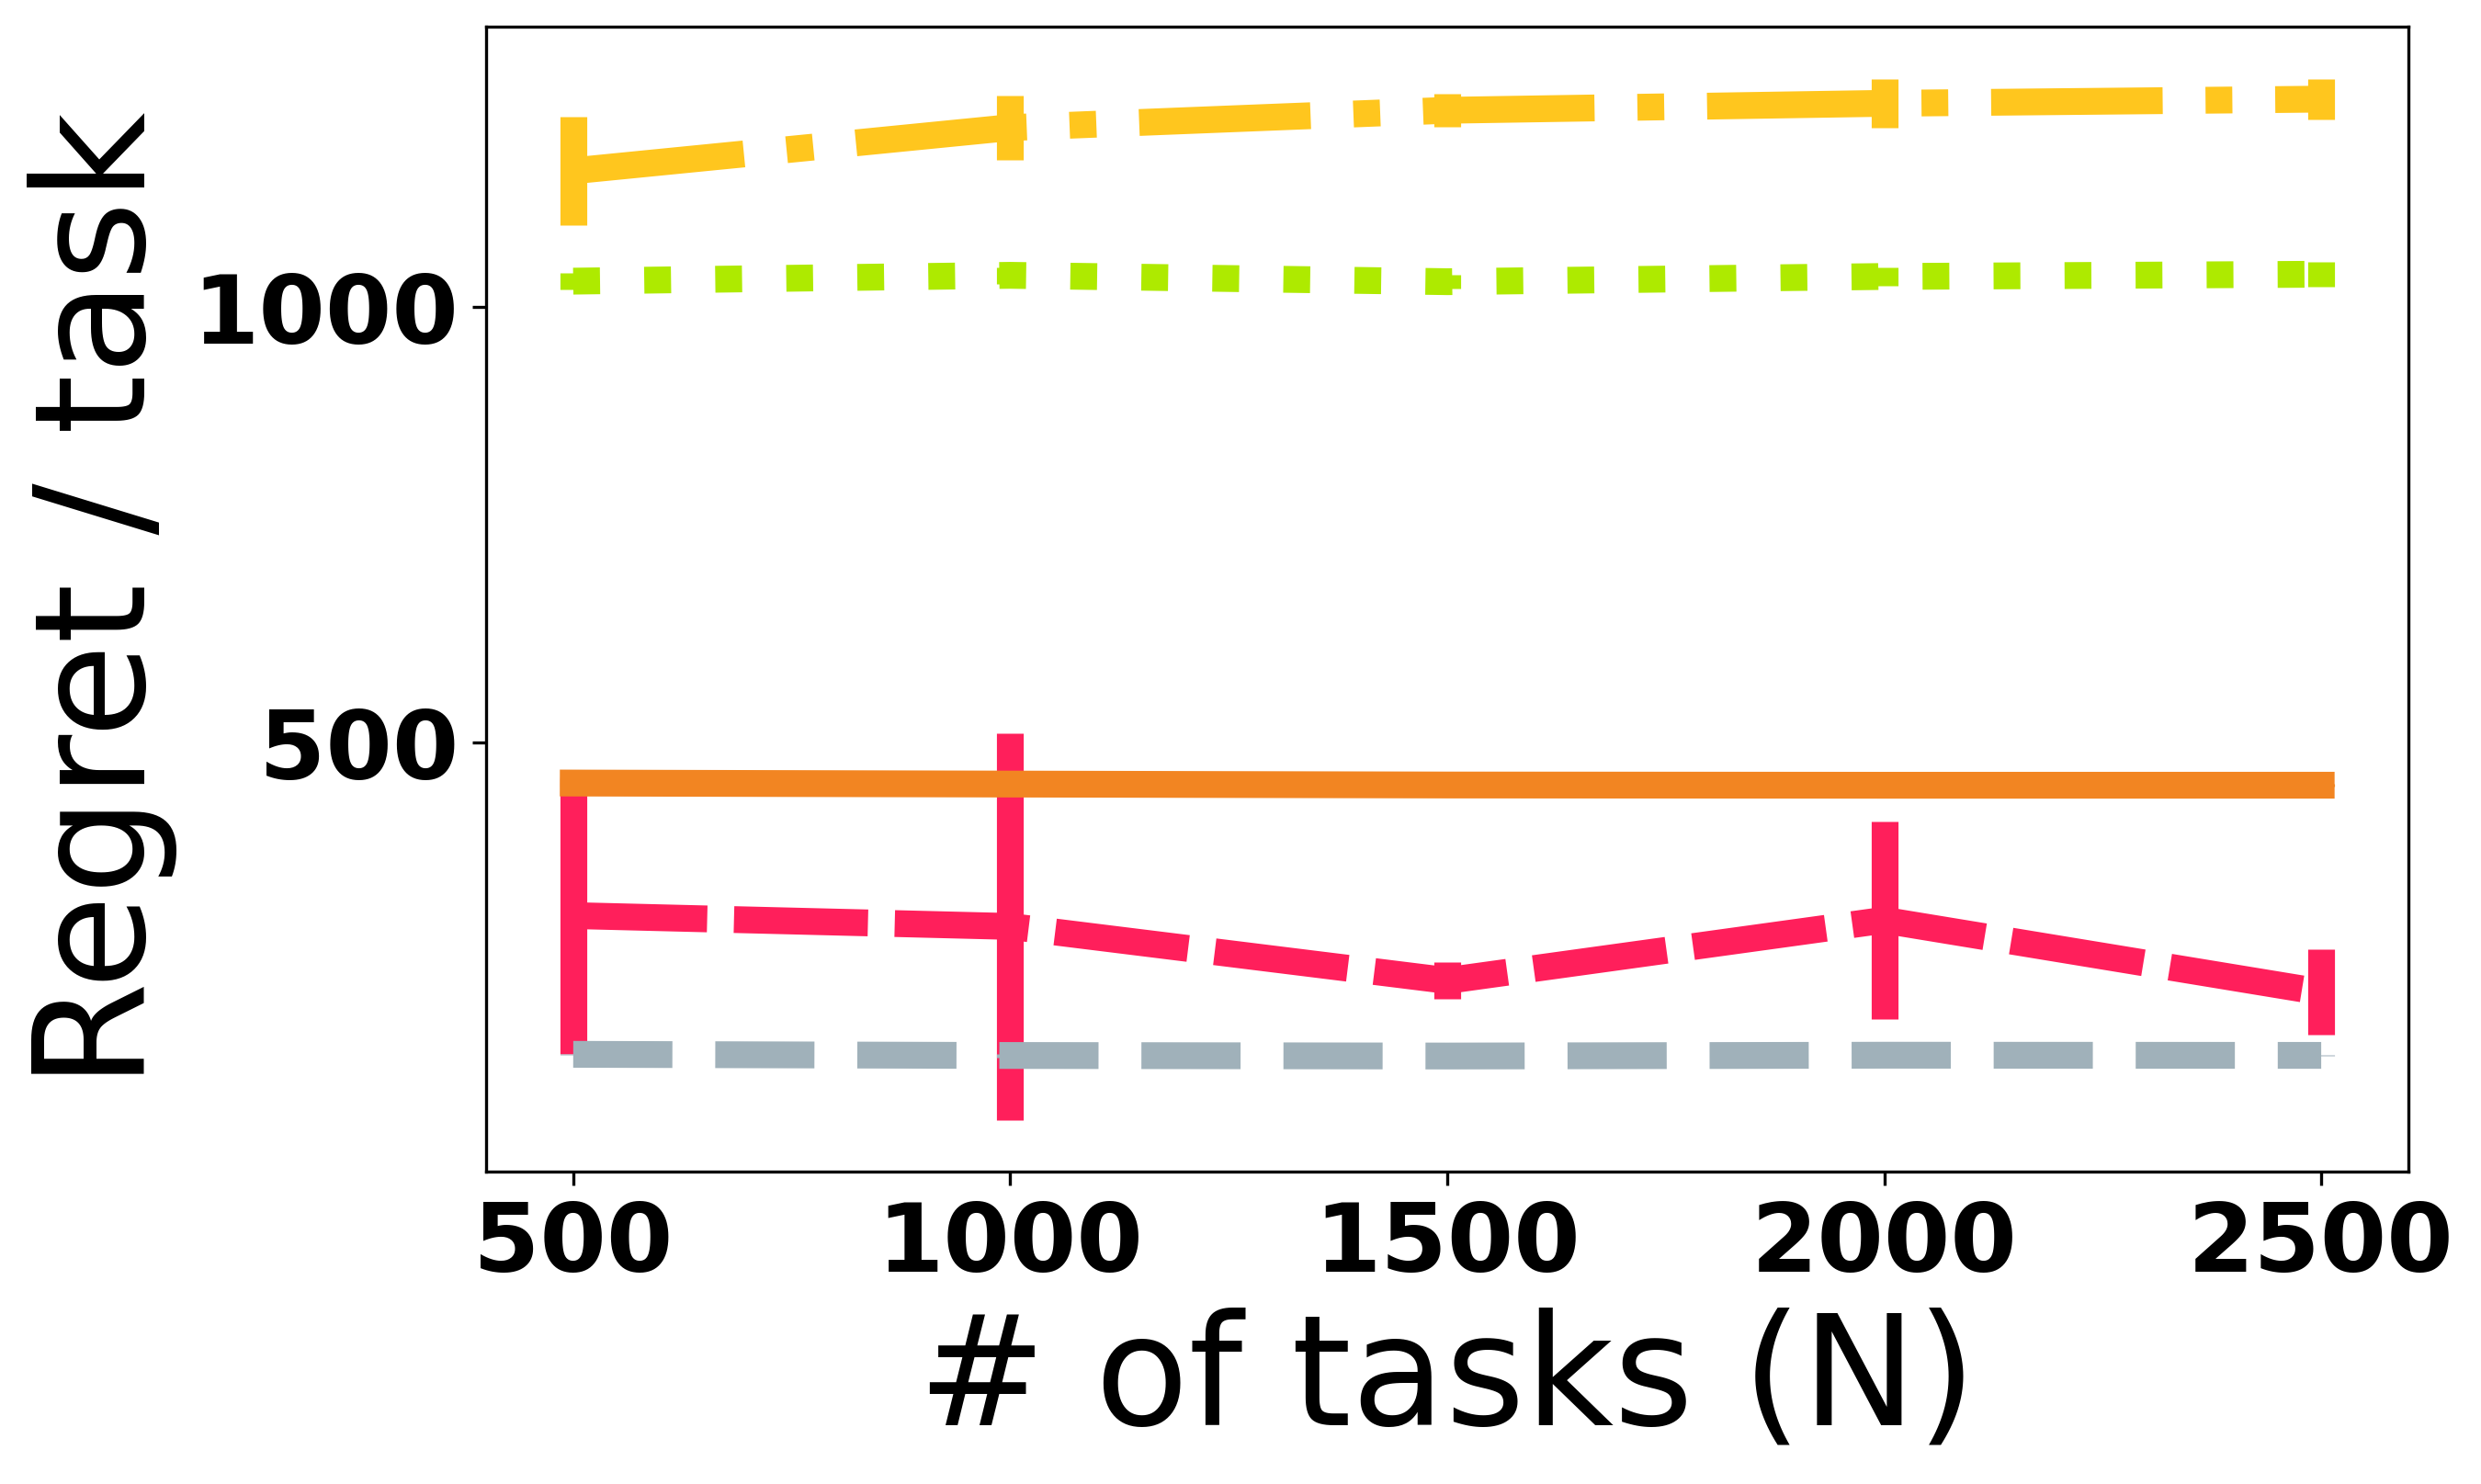

In [7]:
# Plot from loaded cache file
# X = np.arange(100, 501, 100)
X = np.arange(500, 2501, 500)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/tasks.p", "rb"))
utils.plot(X, regret_dict, '', '# of tasks (N)', 'Regret / task', **kwargs)
pass

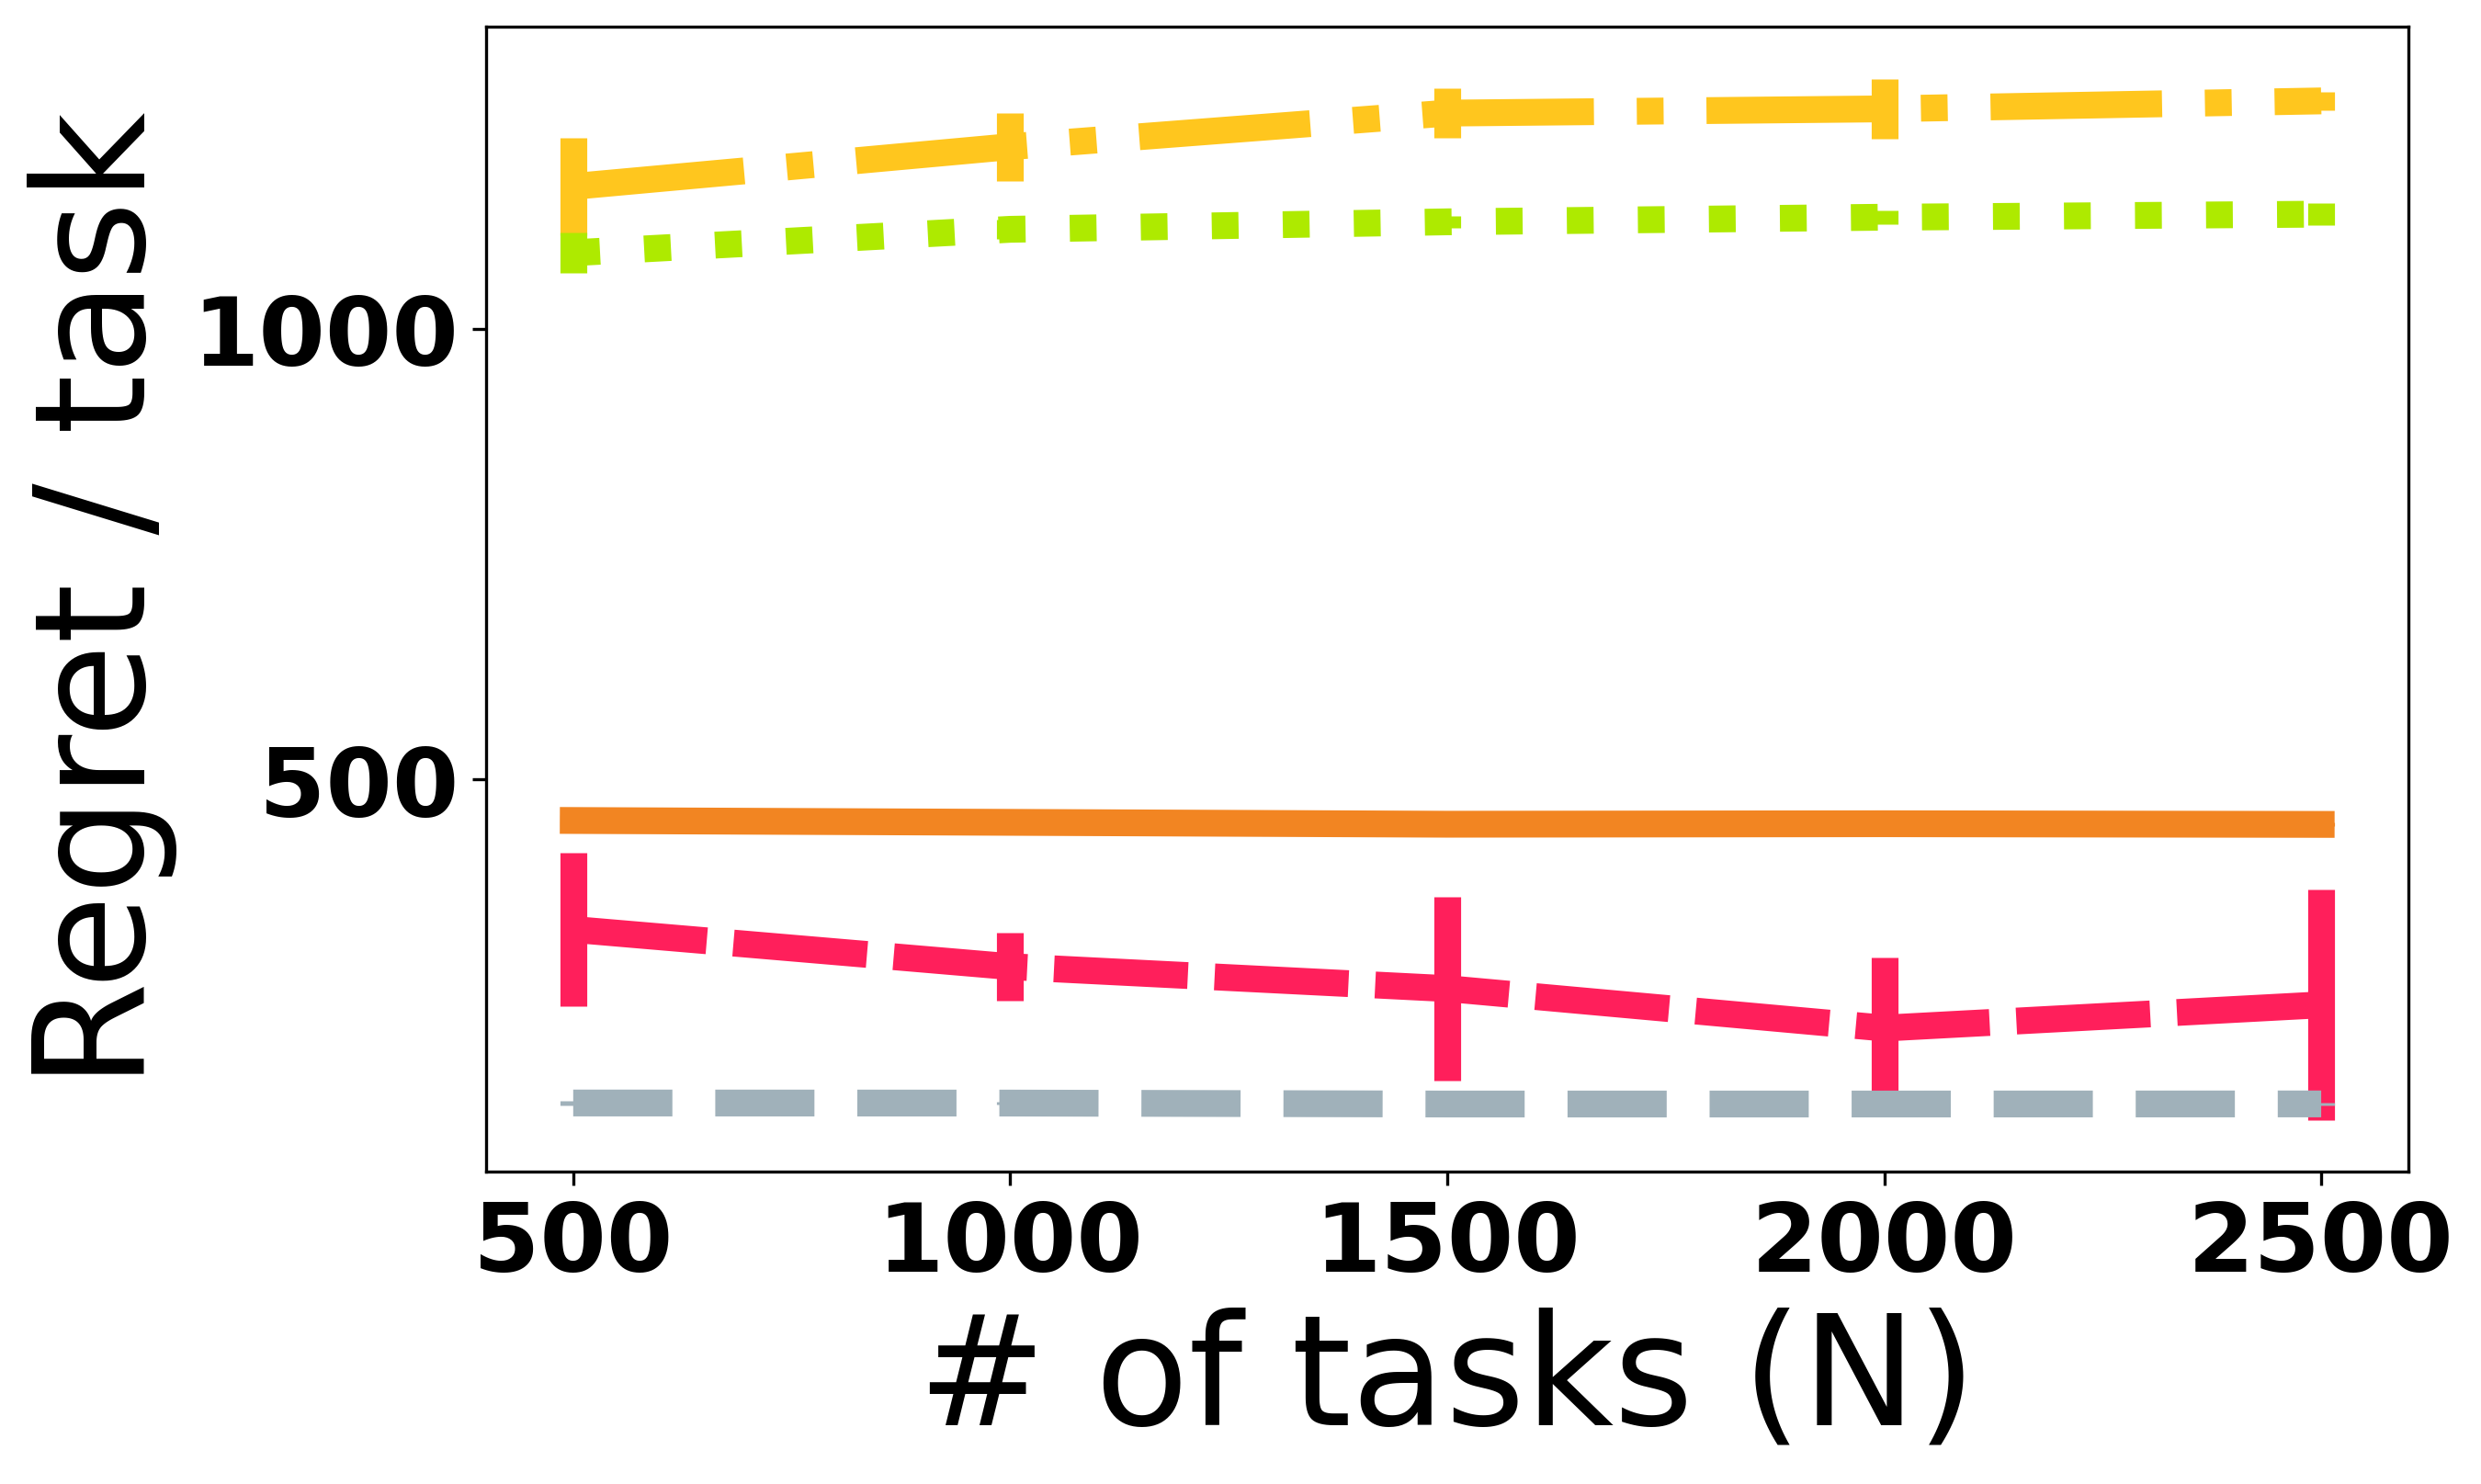

In [4]:
# Plot from loaded cache file
# X = np.arange(100, 501, 100)
X = np.arange(500, 2501, 500)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/tasks.p", "rb"))
utils.plot(X, regret_dict, '', '# of tasks (N)', 'Regret / task', **kwargs)
pass

## Regret vs Horizon

In [ ]:
# horizon_list = np.arange(300, 506, 50)
horizon_list = np.arange(3000, 5006, 500)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
pass

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 204.63it/s]


WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OG gamma: 3.7088650520742523OS_BASS: self.tau_prime = 835, self.gamma = 0.07793317212052633. If gamma > 1, capped at 1.

OS_BASS: self.tau_prime = 835, self.gamma = 0.07793317212052633. If gamma > 1, capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07793317212052633. If gamma > 1, capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07793317212052633. If gamma > 1, capped at 1.OG gamma: 3.7088650520742523

OS_BASS: self.tau_prime = 835, self.gamma = 0.07793317212052633. If gamma > 1, capped at 1.


WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07402983086913796. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07402983086913796. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07402983086913796. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07402983086913796. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.07402983086

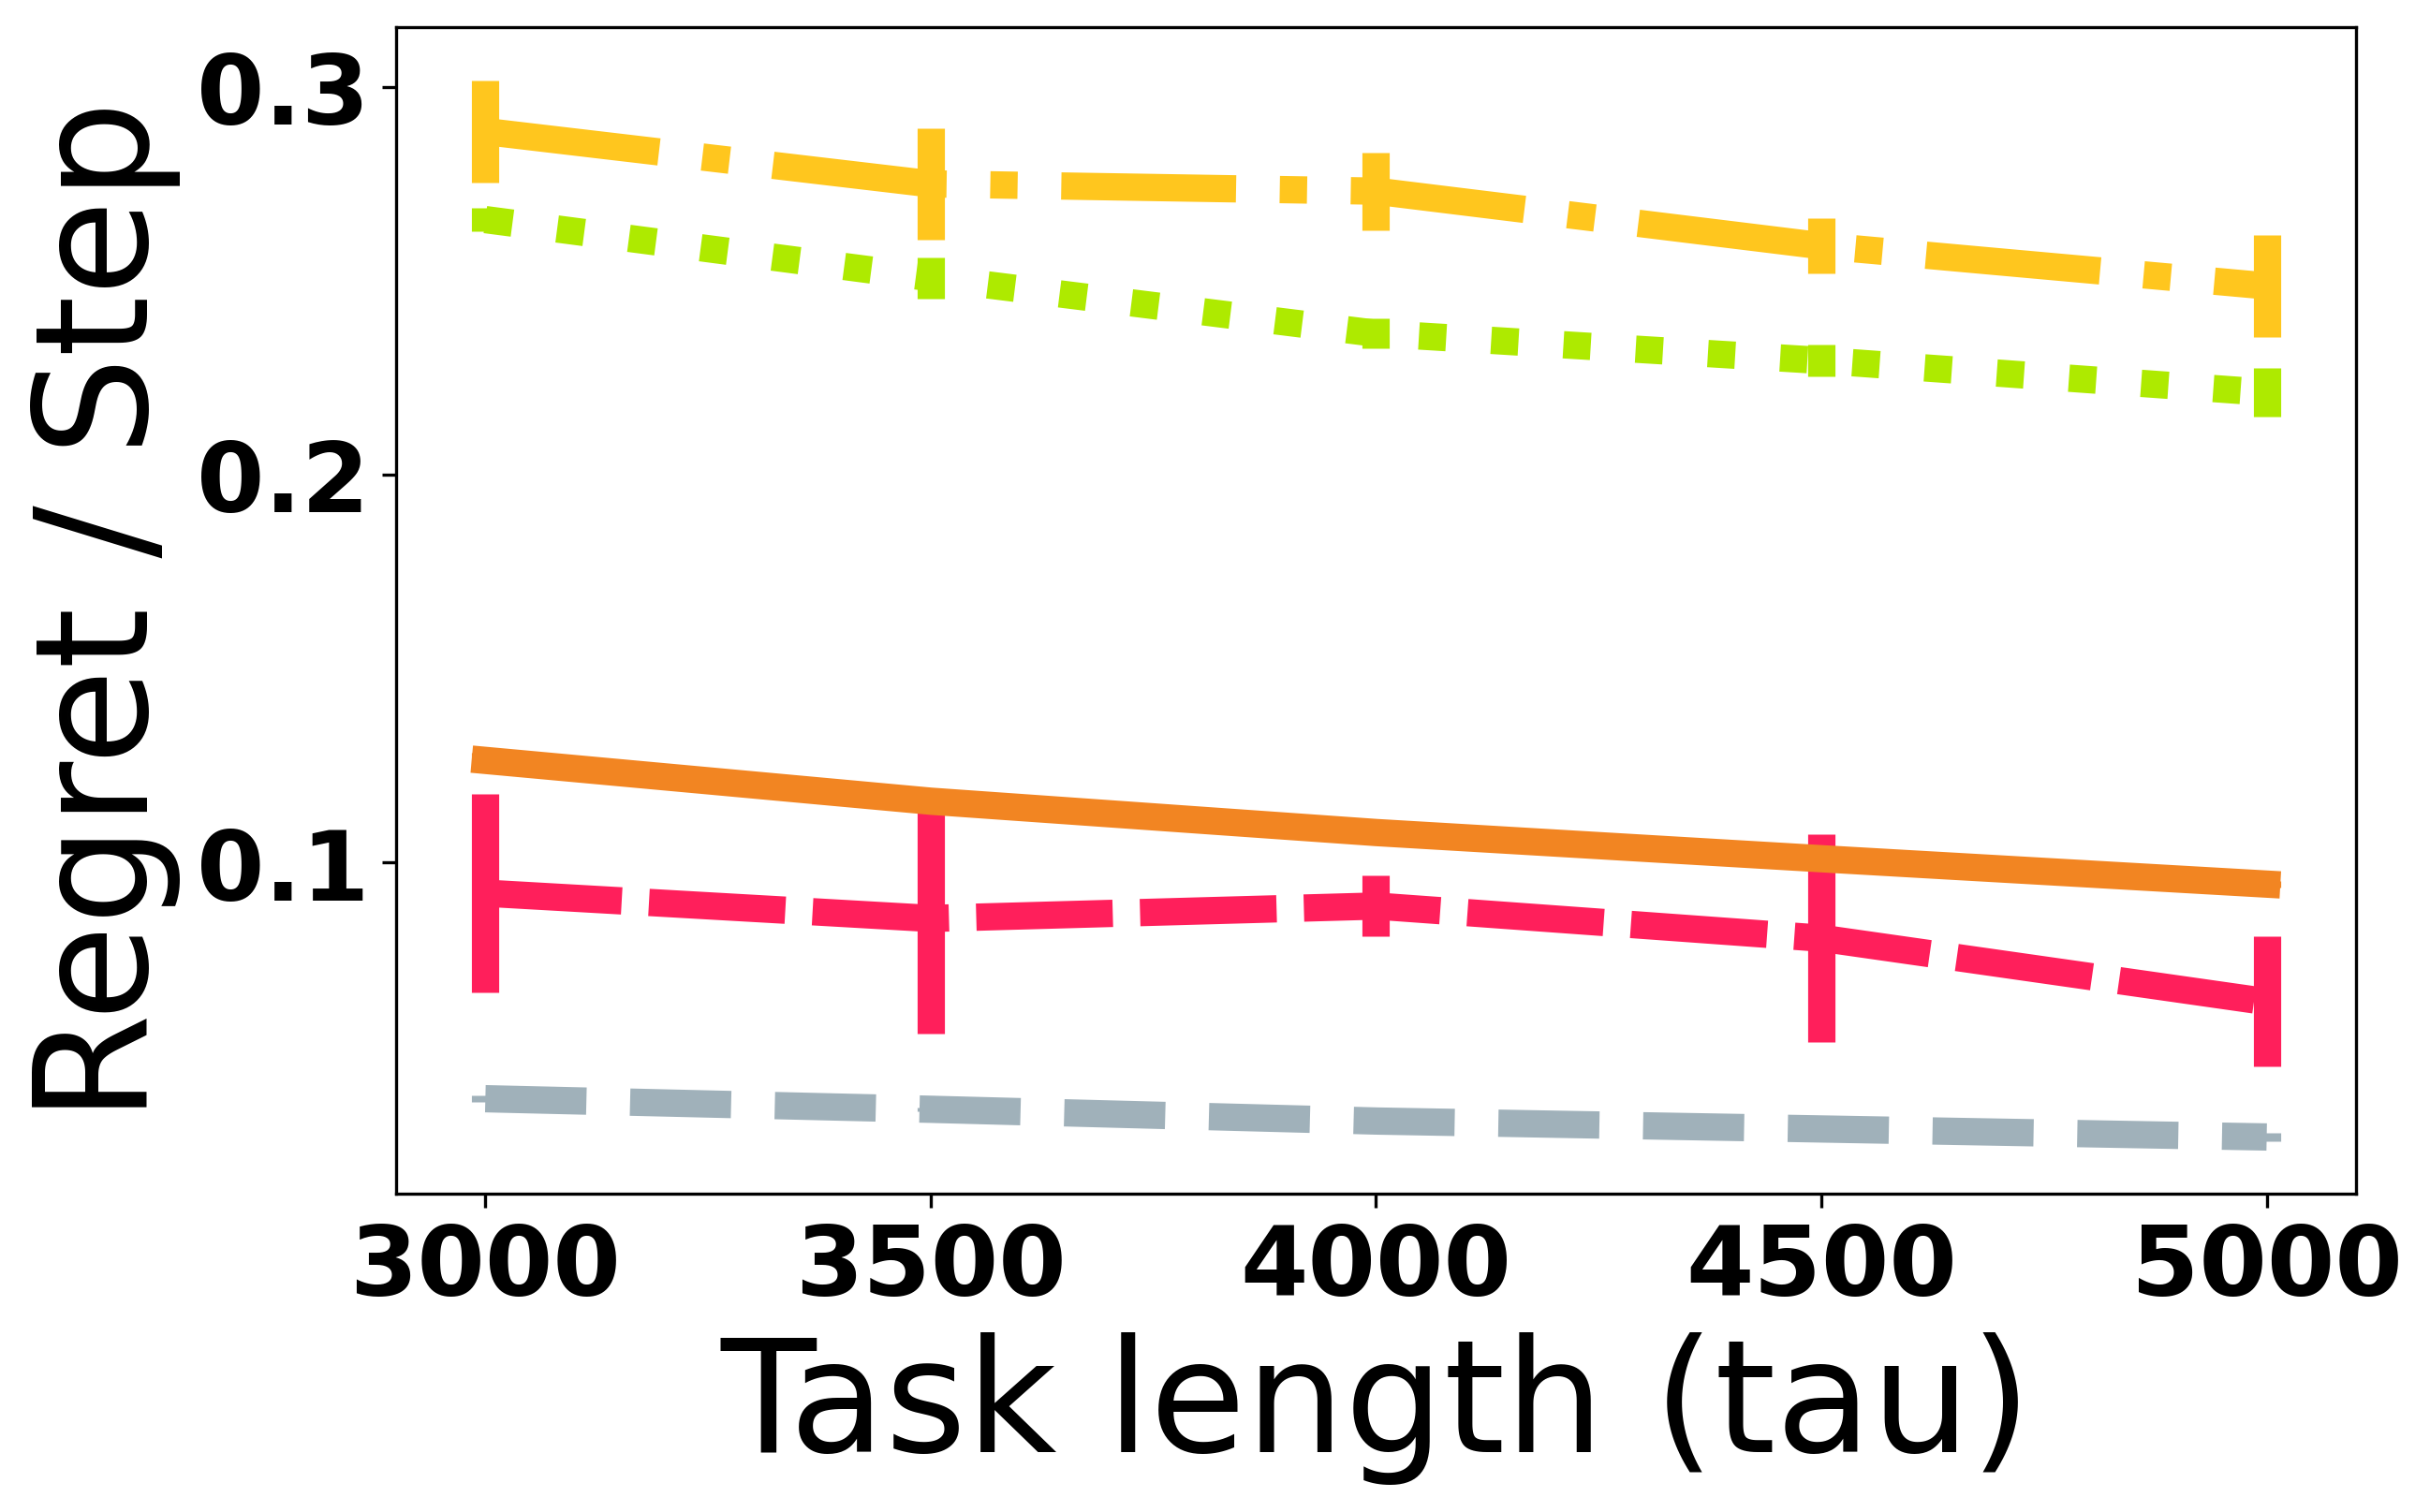

In [8]:
# Plot from loaded cache file
# X_h = np.arange(300, 506, 50)
X_h = np.arange(3000, 5006, 500)
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
utils.plot(X_h, regret_dict_h, '', 'Task length (tau)', 'Regret / Step', **kwargs)
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

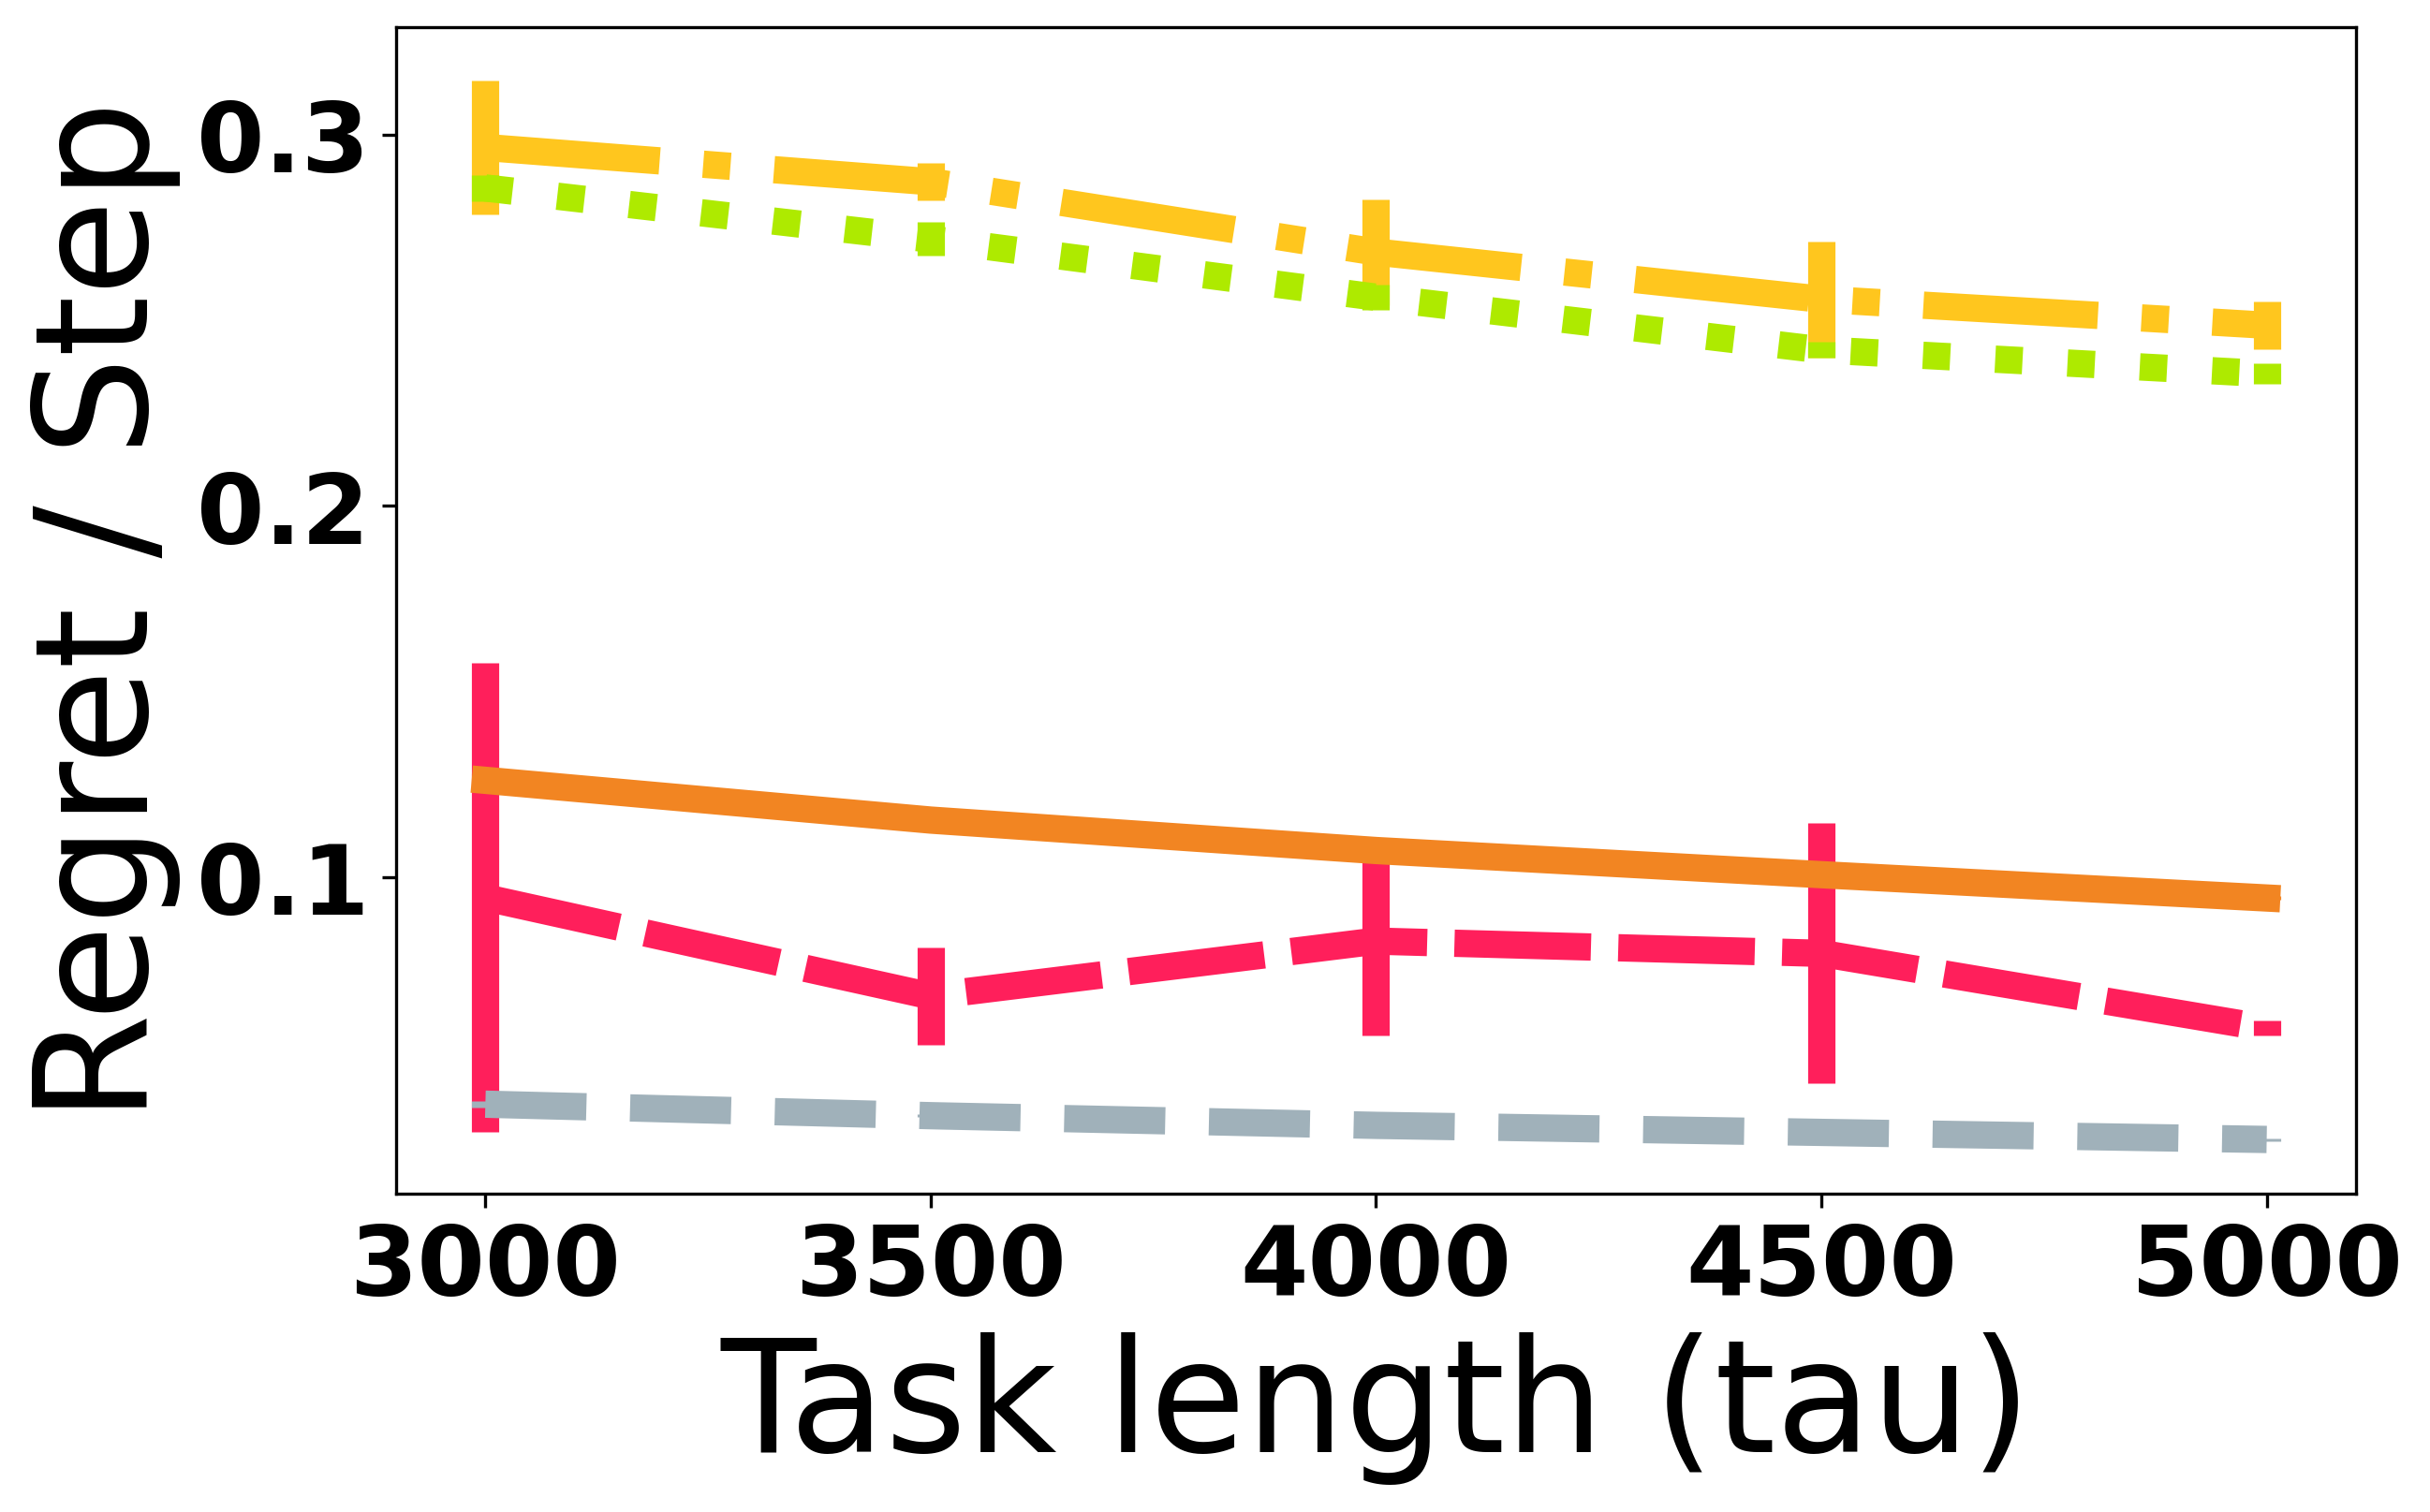

In [6]:
# Plot from loaded cache file
# X_h = np.arange(300, 506, 50)
X_h = np.arange(3000, 5006, 500)
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
utils.plot(X_h, regret_dict_h, '', 'Task length (tau)', 'Regret / Step', **kwargs)
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Regret vs # of arm

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

WARNING (OG baseline): og_gamma (39.24377894995613) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (39.24377894995613) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (39.24377894995613) must in range [0,1]. Capped at 1.


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 282.33it/s]

WARNING (OG baseline): og_gamma (39.24377894995613) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (39.24377894995613) must in range [0,1]. Capped at 1.
OG gamma: 3.4266631327683825
OS_BASS: self.tau_prime = 866, self.gamma = 0.06765914965531432. If gamma > 1, capped at 1.OG gamma: 3.4266631327683825

OG gamma: 3.4266631327683825OS_BASS: self.tau_prime = 866, self.gamma = 0.06765914965531432. If gamma > 1, capped at 1.

OS_BASS: self.tau_prime = 866, self.gamma = 0.06765914965531432. If gamma > 1, capped at 1.
OG gamma: 3.4266631327683825
OS_BASS: self.tau_prime = 866, self.gamma = 0.06765914965531432. If gamma > 1, capped at 1.
OG gamma: 3.4266631327683825
OS_BASS: self.tau_prime = 866, self.gamma = 0.06765914965531432. If gamma > 1, capped at 1.


WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.06808089671942337. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.06808089671942337. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.06808089671942337. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.06808089671942337. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (42.47568979482105) must in range [0,1]. Capped at 1.
OG gamma: 3.7088650520742523
OS_BASS: self.tau_prime = 835, self.gamma = 0.06808089671

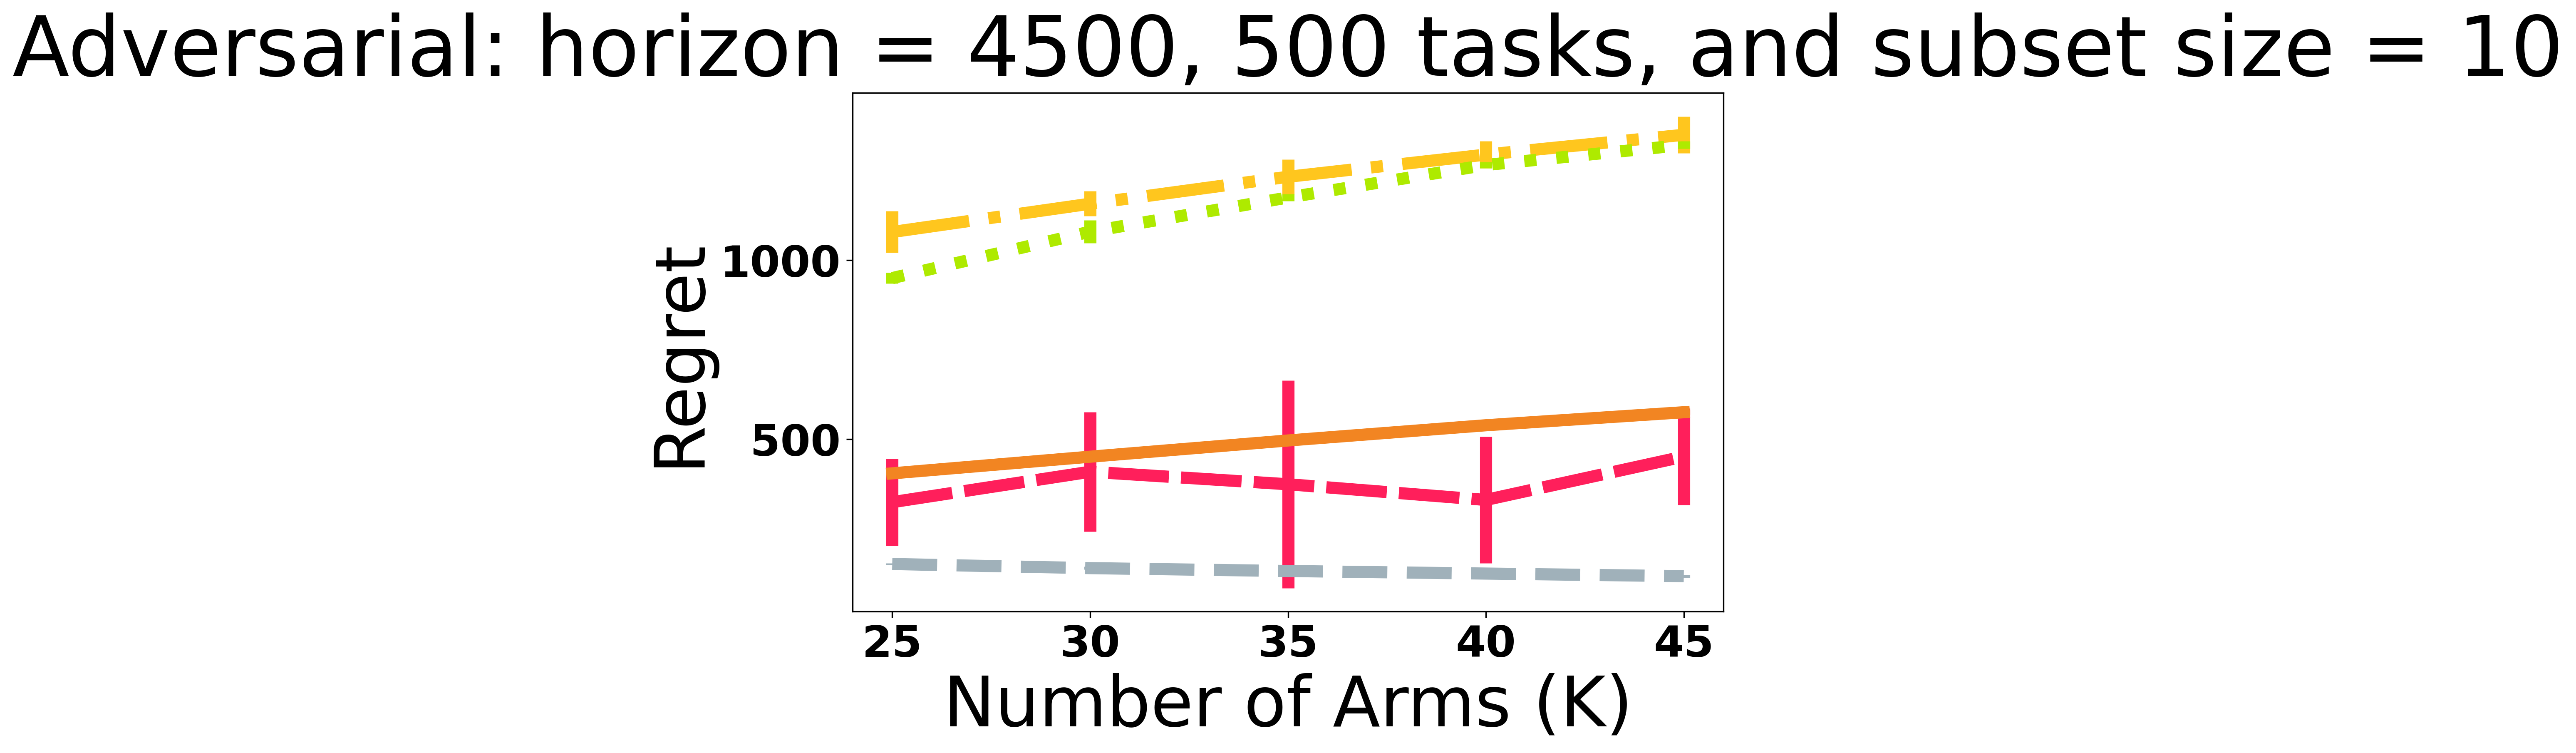

In [4]:
# n_arms_list = np.arange(10,19,2)
n_arms_list = np.arange(25,46,5)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, OPT_SIZE, HORIZON, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
pass

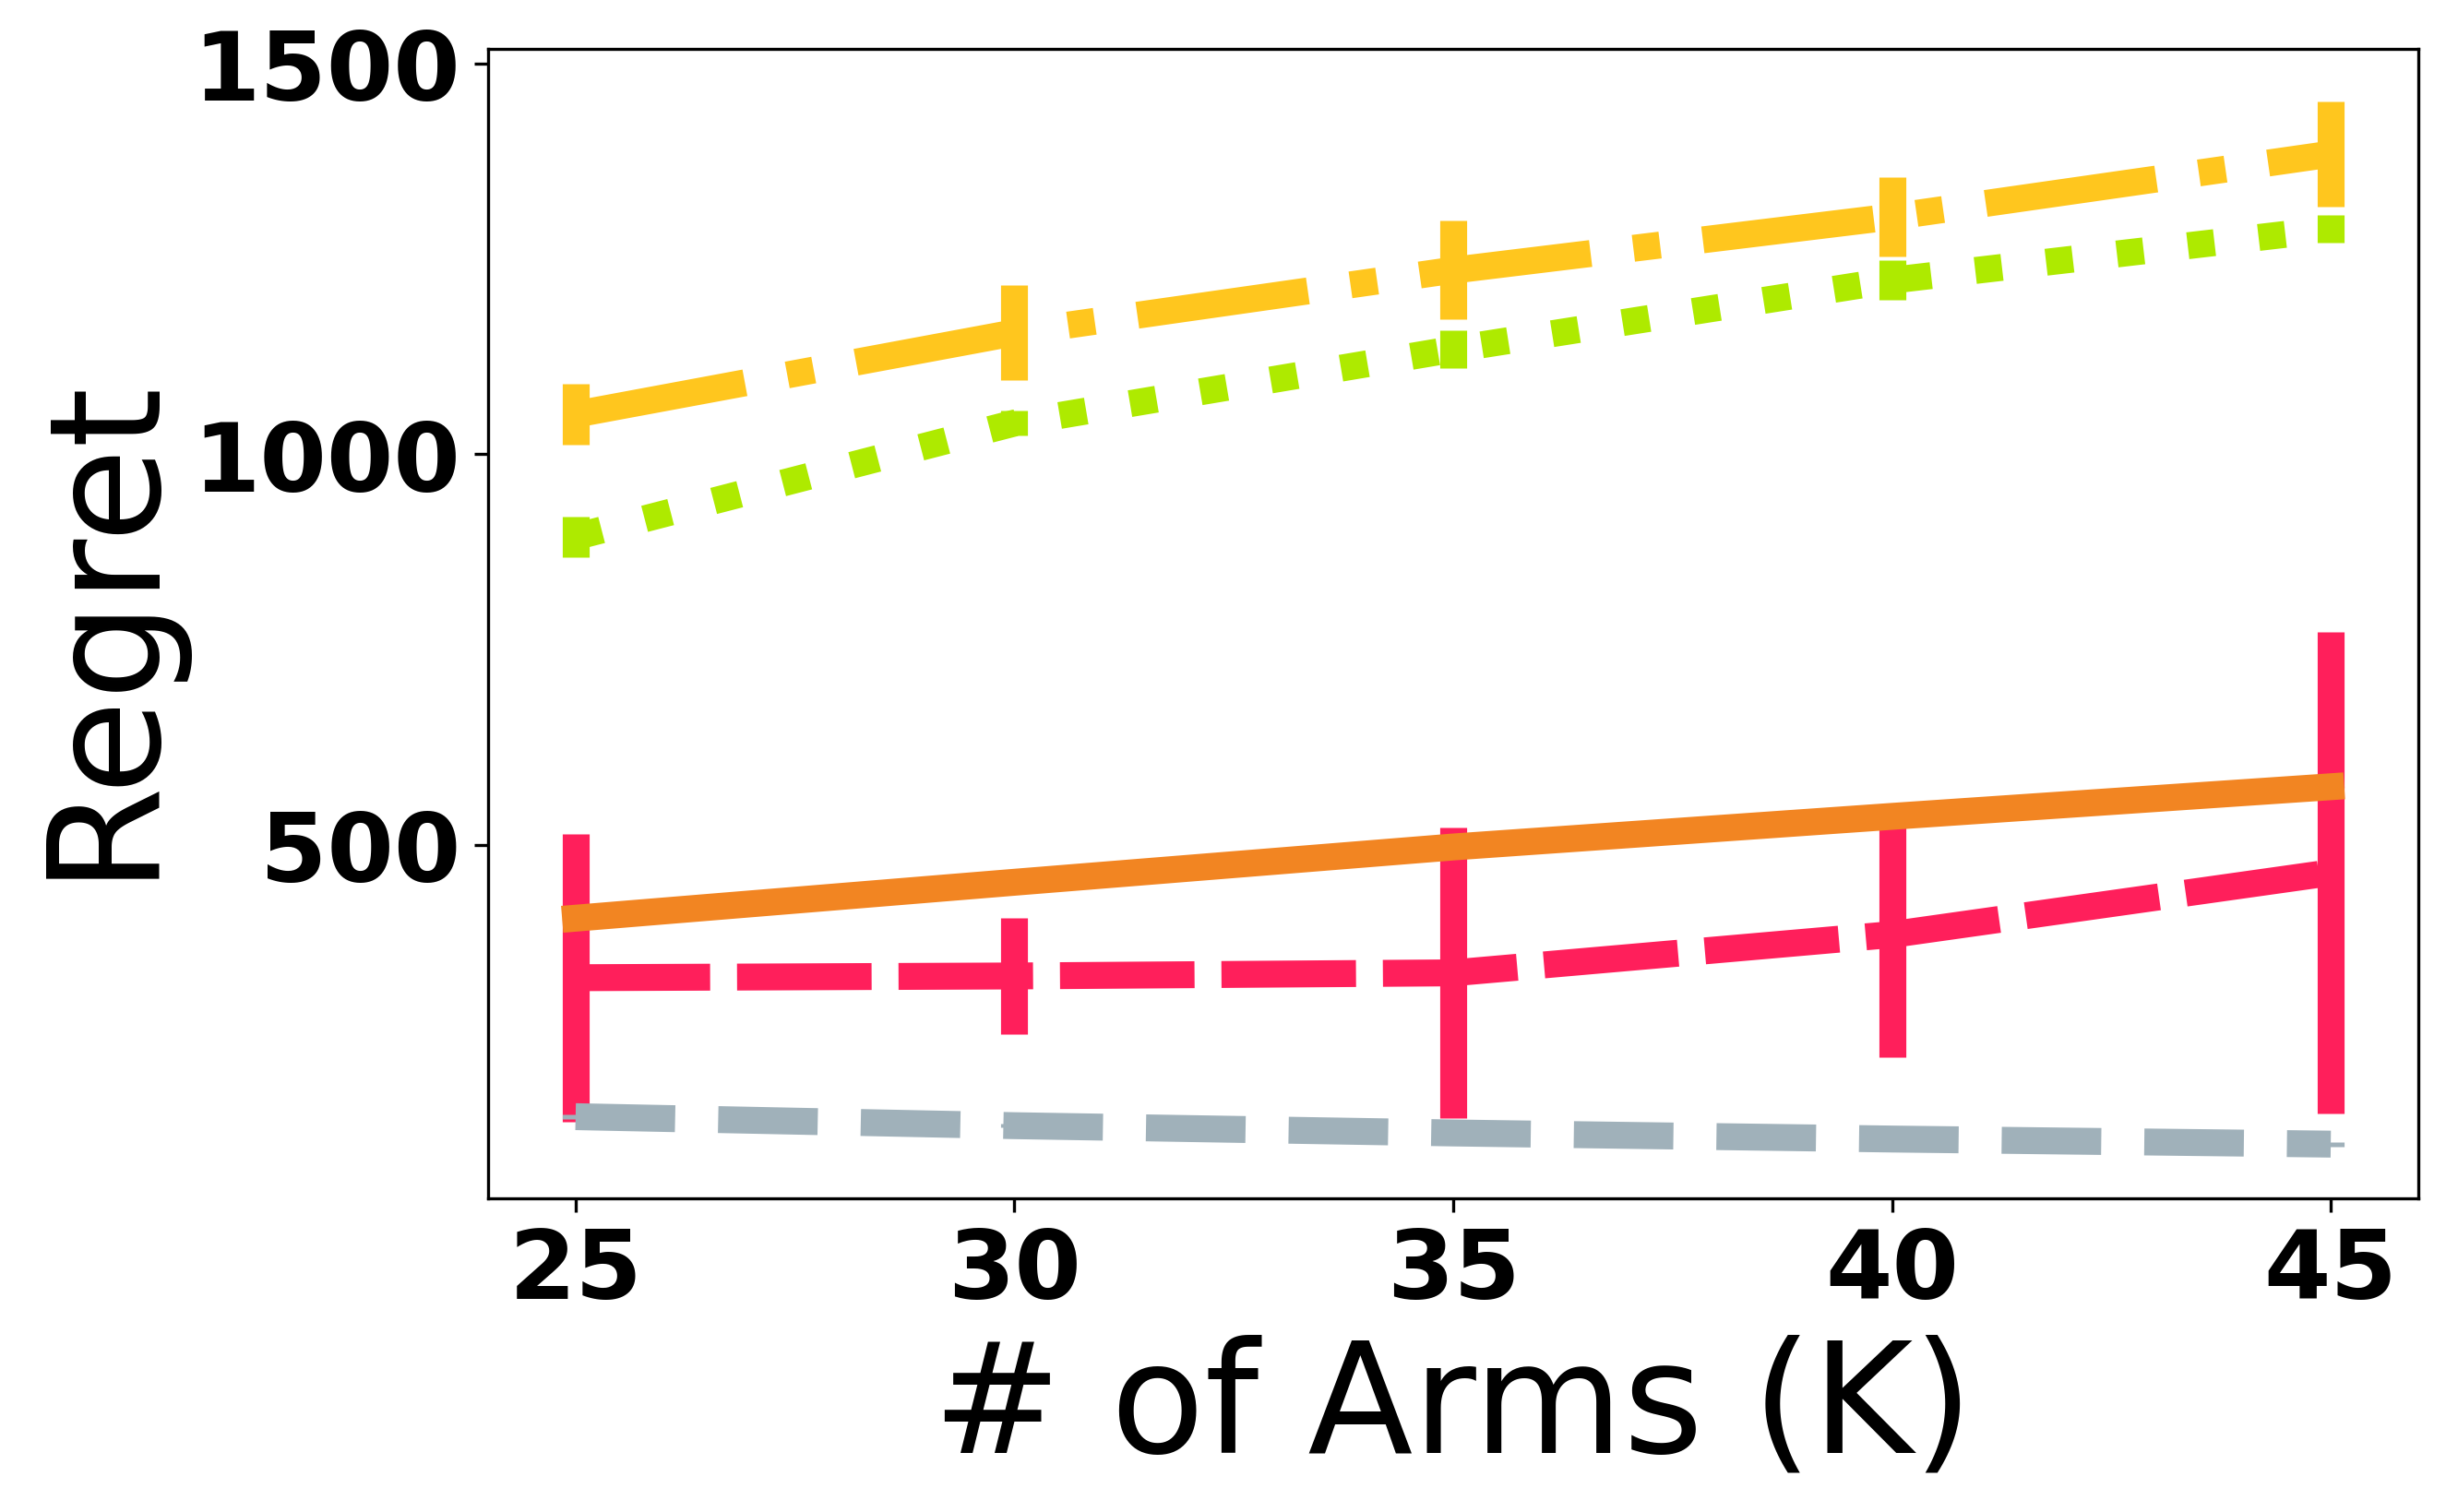

In [9]:
# Plot from loaded cache file
# X_b = np.arange(10,19,2)
X_b = np.arange(25,46,5)
regret_dict_b = pickle.load(open("results/arms.p", "rb"))
utils.plot(X_b, regret_dict_b, '', '# of Arms (K)', 'Regret', **kwargs)

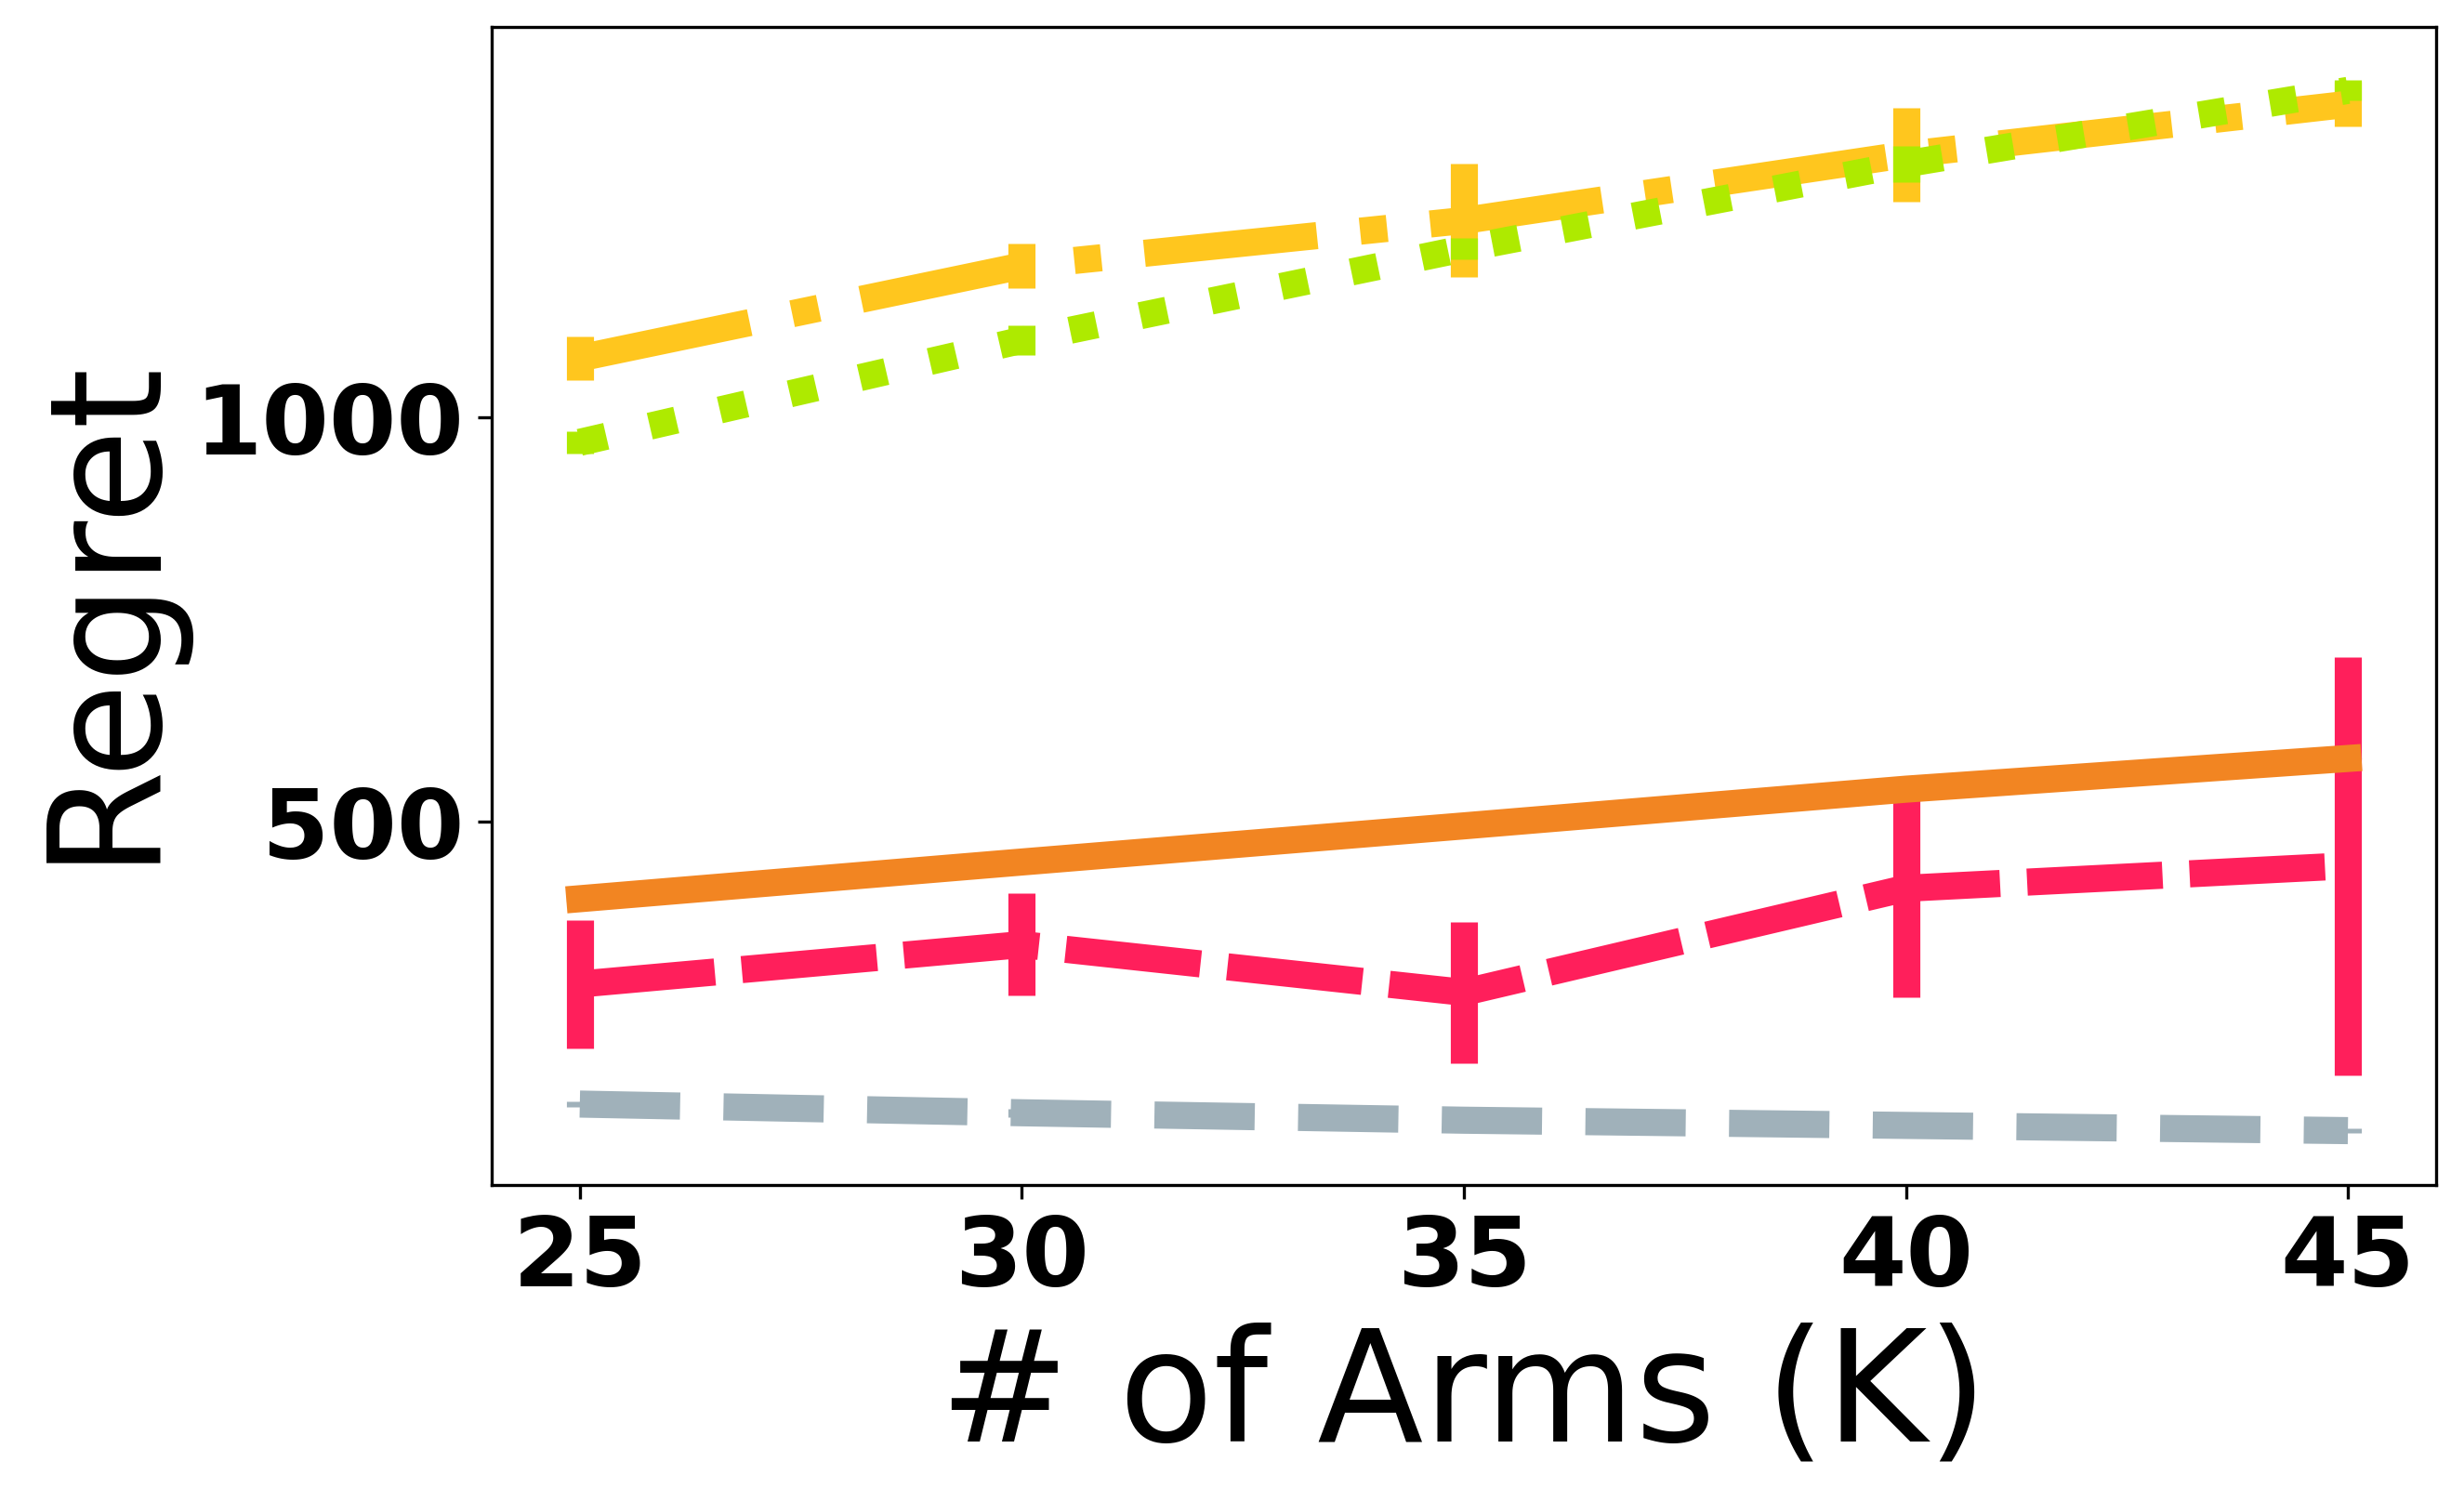

In [8]:
# Plot from loaded cache file
# X_b = np.arange(10,19,2)
X_b = np.arange(25,46,5)
regret_dict_b = pickle.load(open("results/arms.p", "rb"))
utils.plot(X_b, regret_dict_b, '', '# of Arms (K)', 'Regret', **kwargs)

## Regret vs subset size

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

WARNING (OG baseline): og_gamma (8.495137958964209) must in range [0,1]. Capped at 1.WARNING (OG baseline): og_gamma (8.495137958964209) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (8.495137958964209) must in range [0,1]. Capped at 1.


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 355.84it/s]

WARNING (OG baseline): og_gamma (8.495137958964209) must in range [0,1]. Capped at 1.
WARNING (OG baseline): og_gamma (8.495137958964209) must in range [0,1]. Capped at 1.
OS_BASS: self.tau_prime = 167, self.gamma = 0.039813949928206416. If gamma > 1, capped at 1.OS_BASS: self.tau_prime = 167, self.gamma = 0.039813949928206416. If gamma > 1, capped at 1.

OS_BASS: self.tau_prime = 167, self.gamma = 0.039813949928206416. If gamma > 1, capped at 1.
OS_BASS: self.tau_prime = 167, self.gamma = 0.039813949928206416. If gamma > 1, capped at 1.
OS_BASS: self.tau_prime = 167, self.gamma = 0.039813949928206416. If gamma > 1, capped at 1.


WARNING (OG baseline): og_gamma (16.990275917928418) must in range [0,1]. Capped at 1.
OG gamma: 1.4835460208297009
OS_BASS: self.tau_prime = 334, self.gamma = 0.05016243359400773. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (16.990275917928418) must in range [0,1]. Capped at 1.
OG gamma: 1.4835460208297009
OS_BASS: self.tau_prime = 334, self.gamma = 0.05016243359400773. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (16.990275917928418) must in range [0,1]. Capped at 1.
OG gamma: 1.4835460208297009
OS_BASS: self.tau_prime = 334, self.gamma = 0.05016243359400773. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (16.990275917928418) must in range [0,1]. Capped at 1.
OG gamma: 1.4835460208297009
OS_BASS: self.tau_prime = 334, self.gamma = 0.05016243359400773. If gamma > 1, capped at 1.
WARNING (OG baseline): og_gamma (16.990275917928418) must in range [0,1]. Capped at 1.
OG gamma: 1.4835460208297009
OS_BASS: self.tau_prime = 334, self.gamma = 0.050162

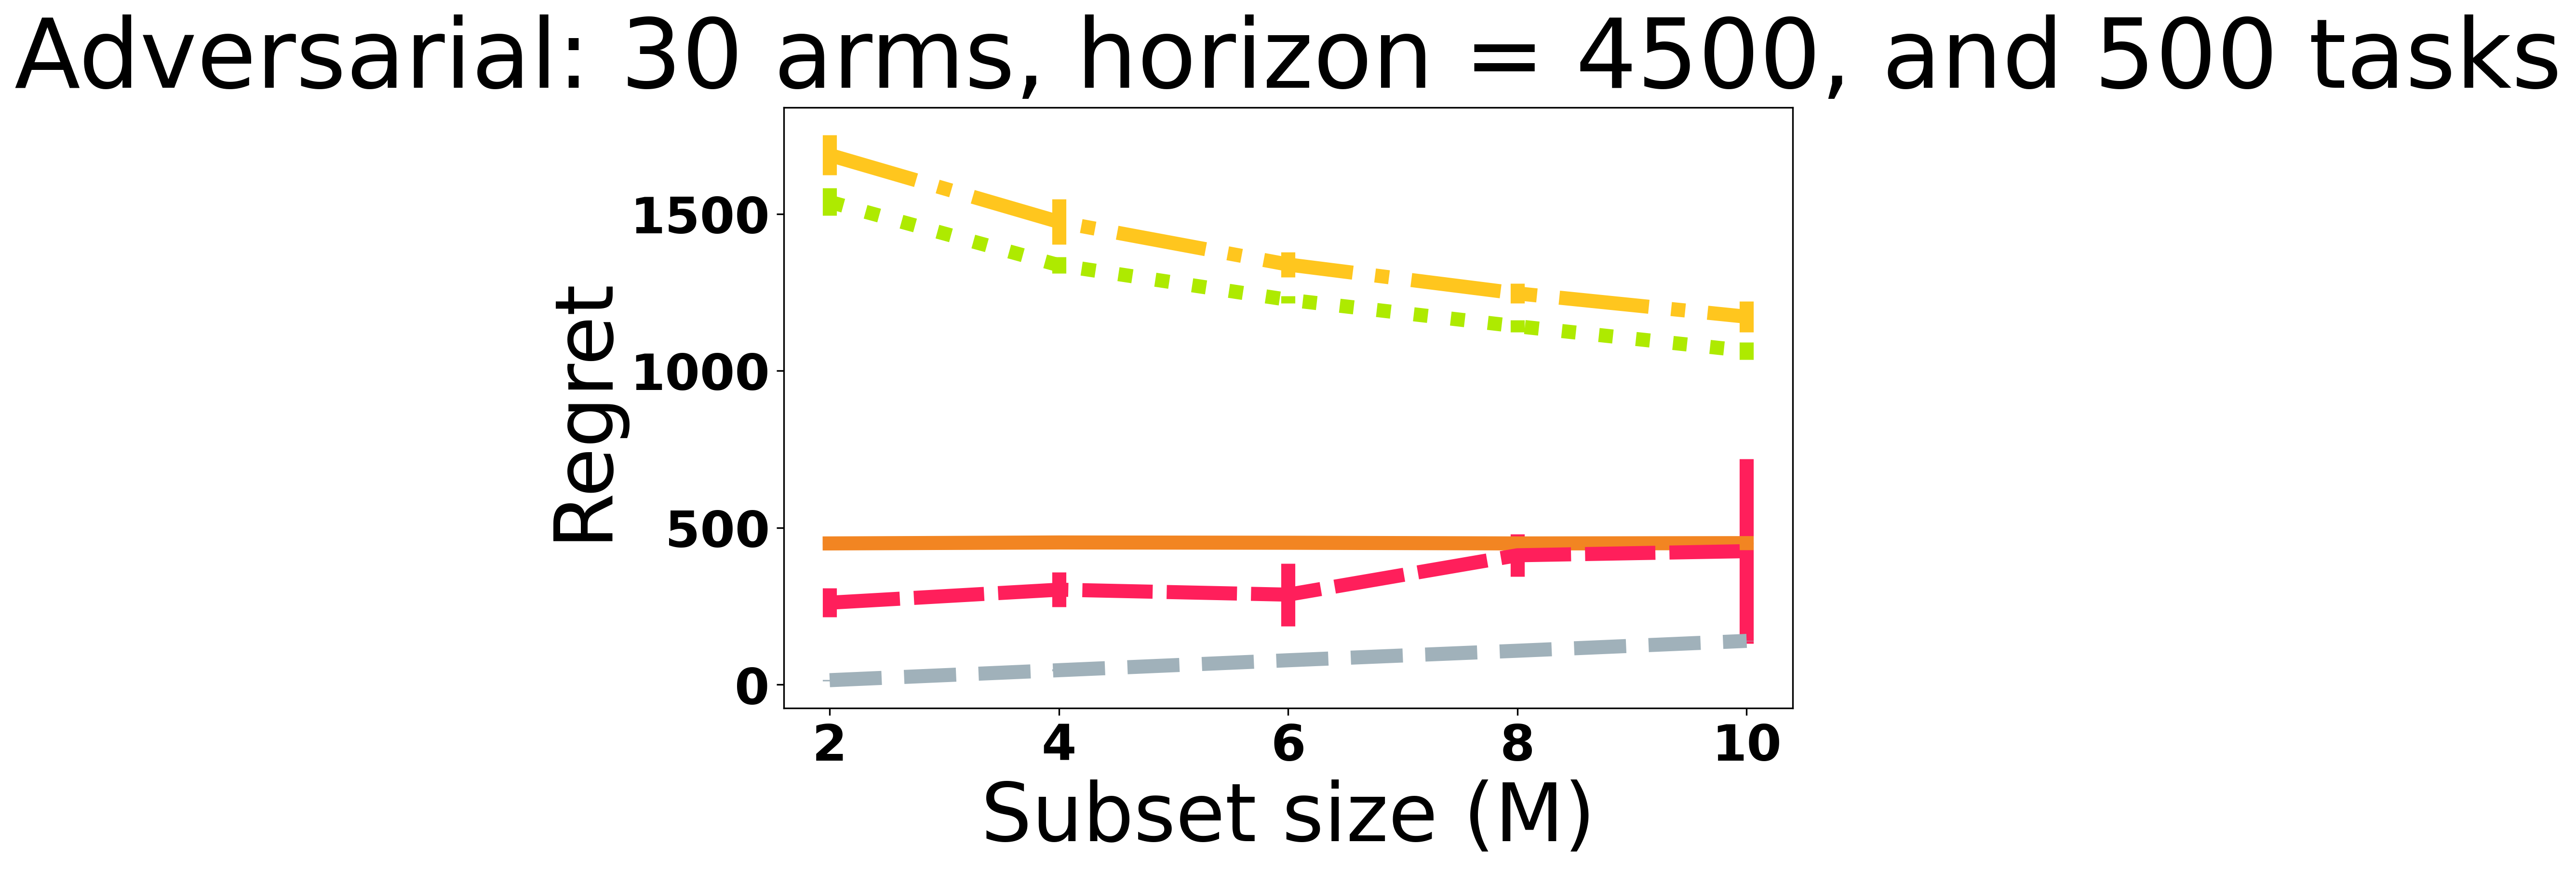

In [3]:
opt_size_list = np.arange(2,11,2)
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = opt_size_list, **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
pass

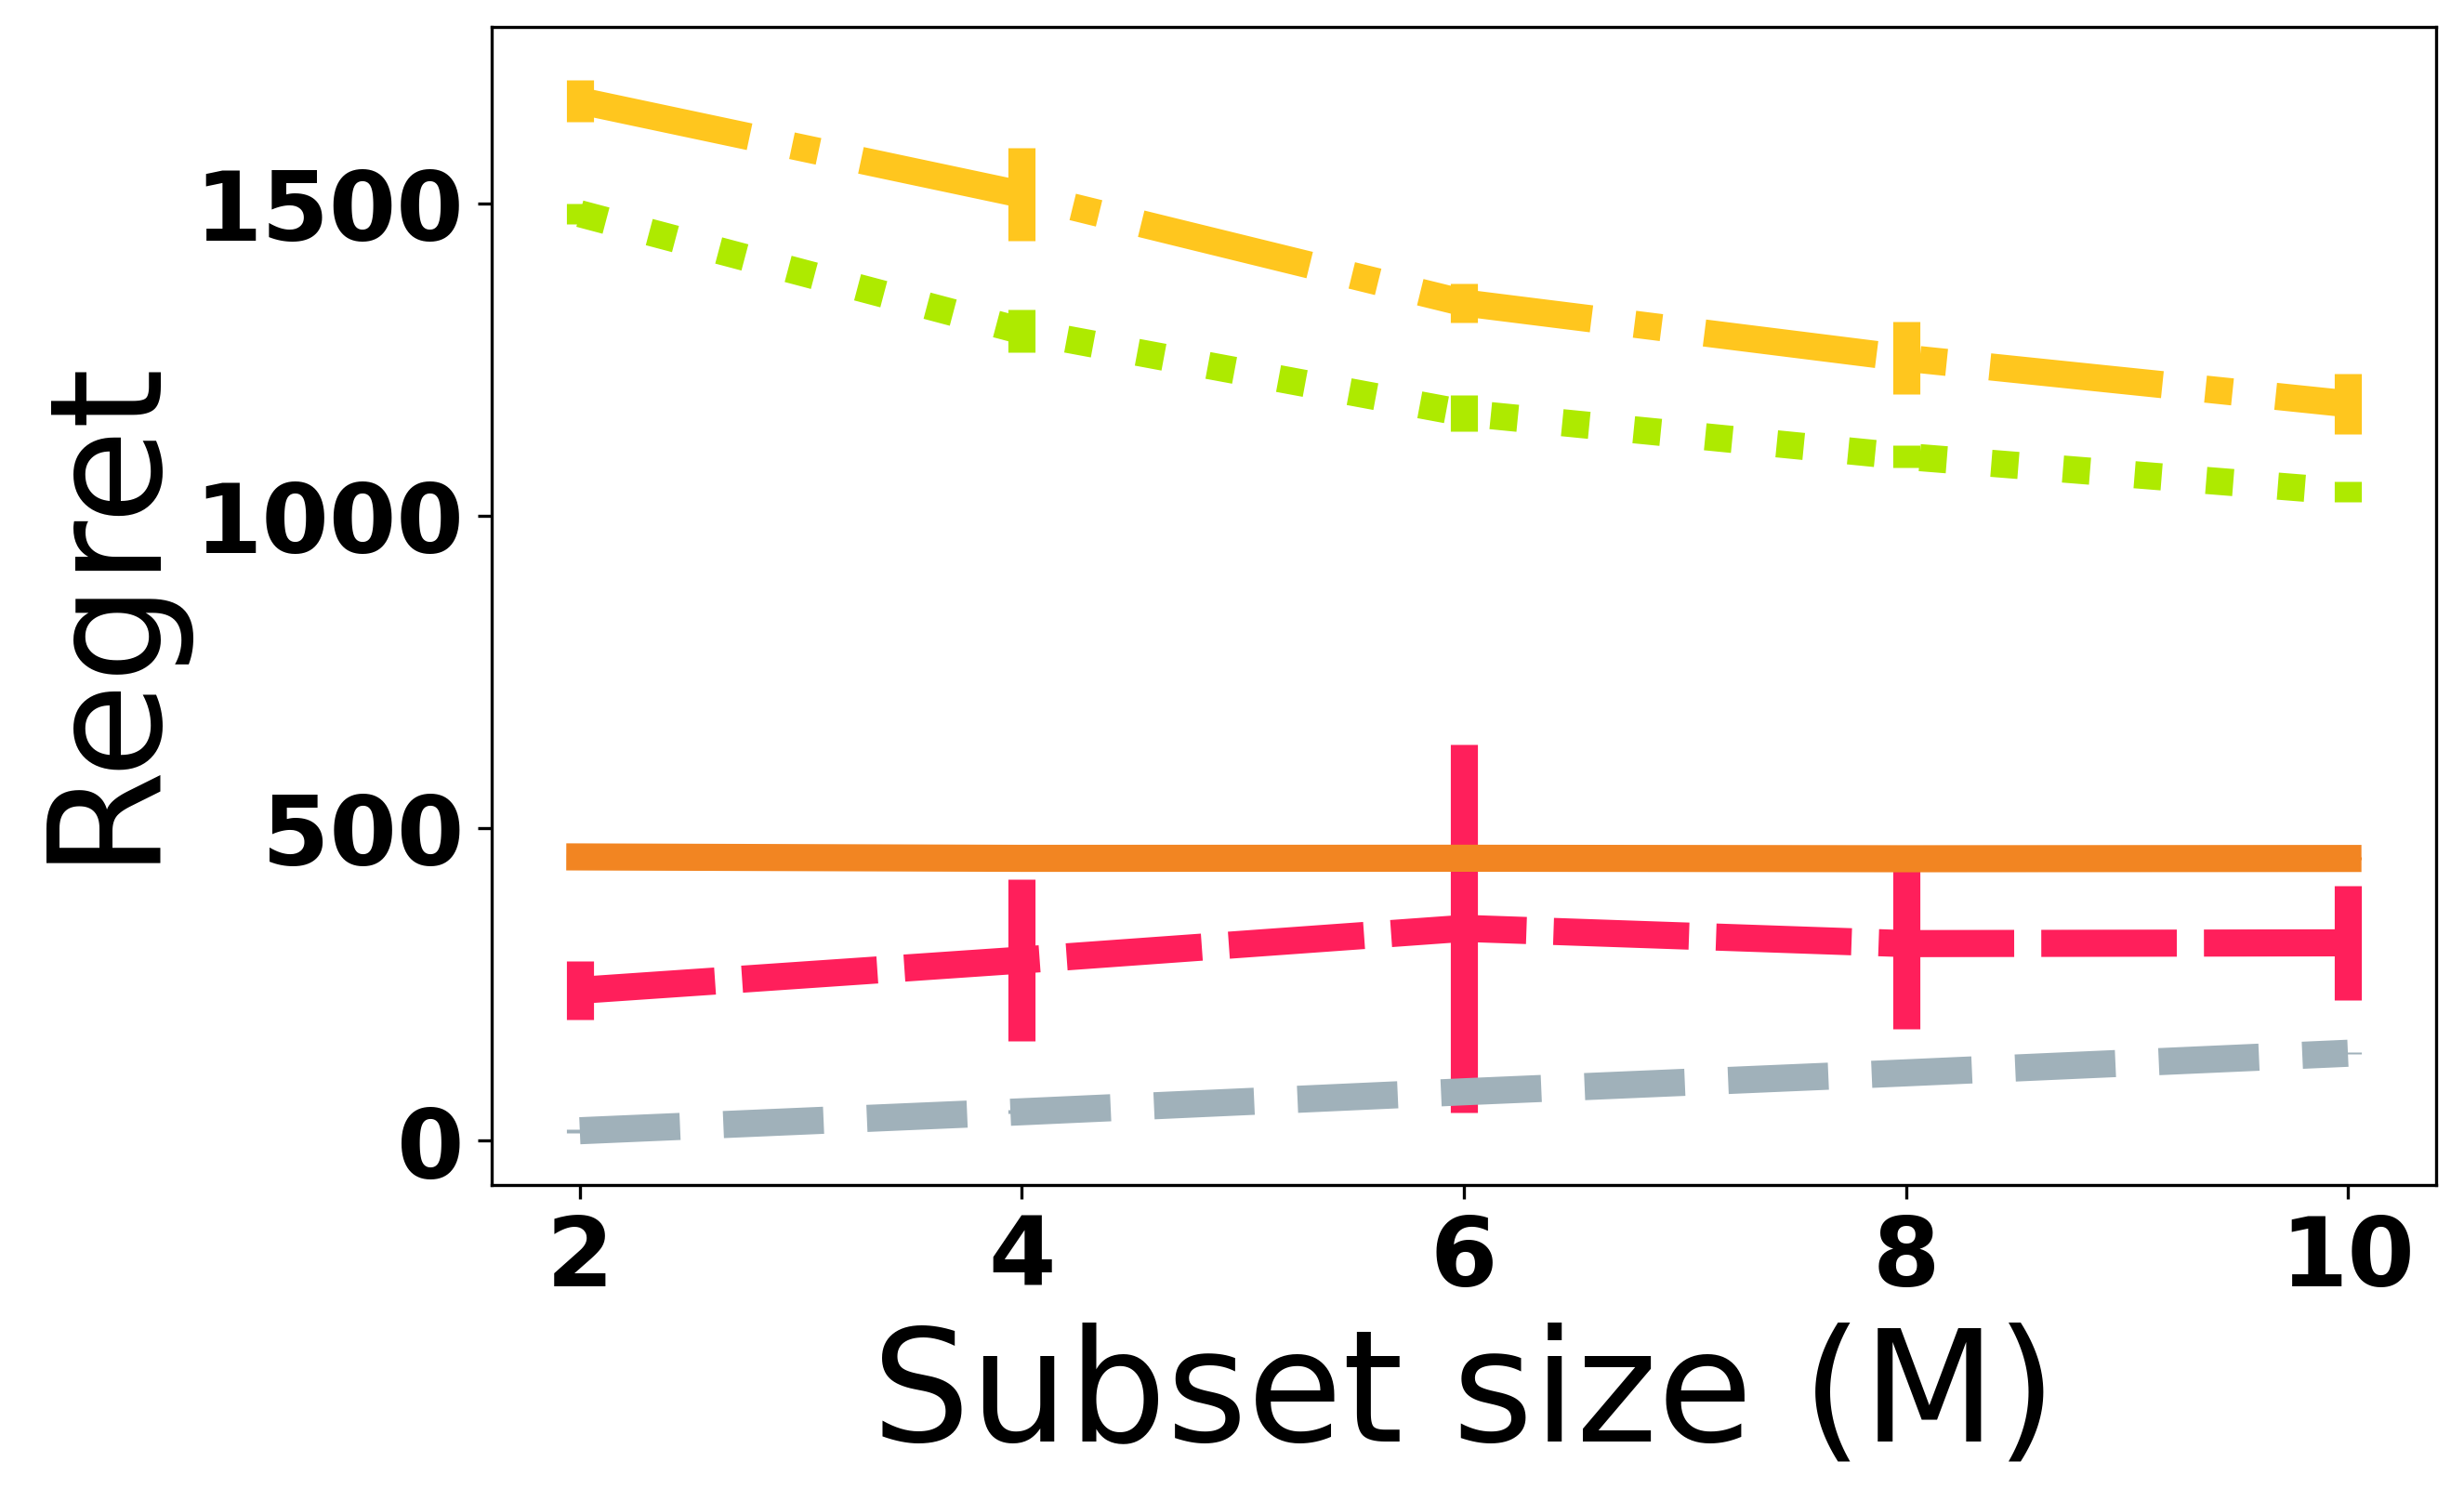

In [10]:
# Plot from loaded cache file
X_e = np.arange(2,11,2)
regret_dict_e = pickle.load(open("results/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, '', 'Subset size (M)', 'Regret', **kwargs)

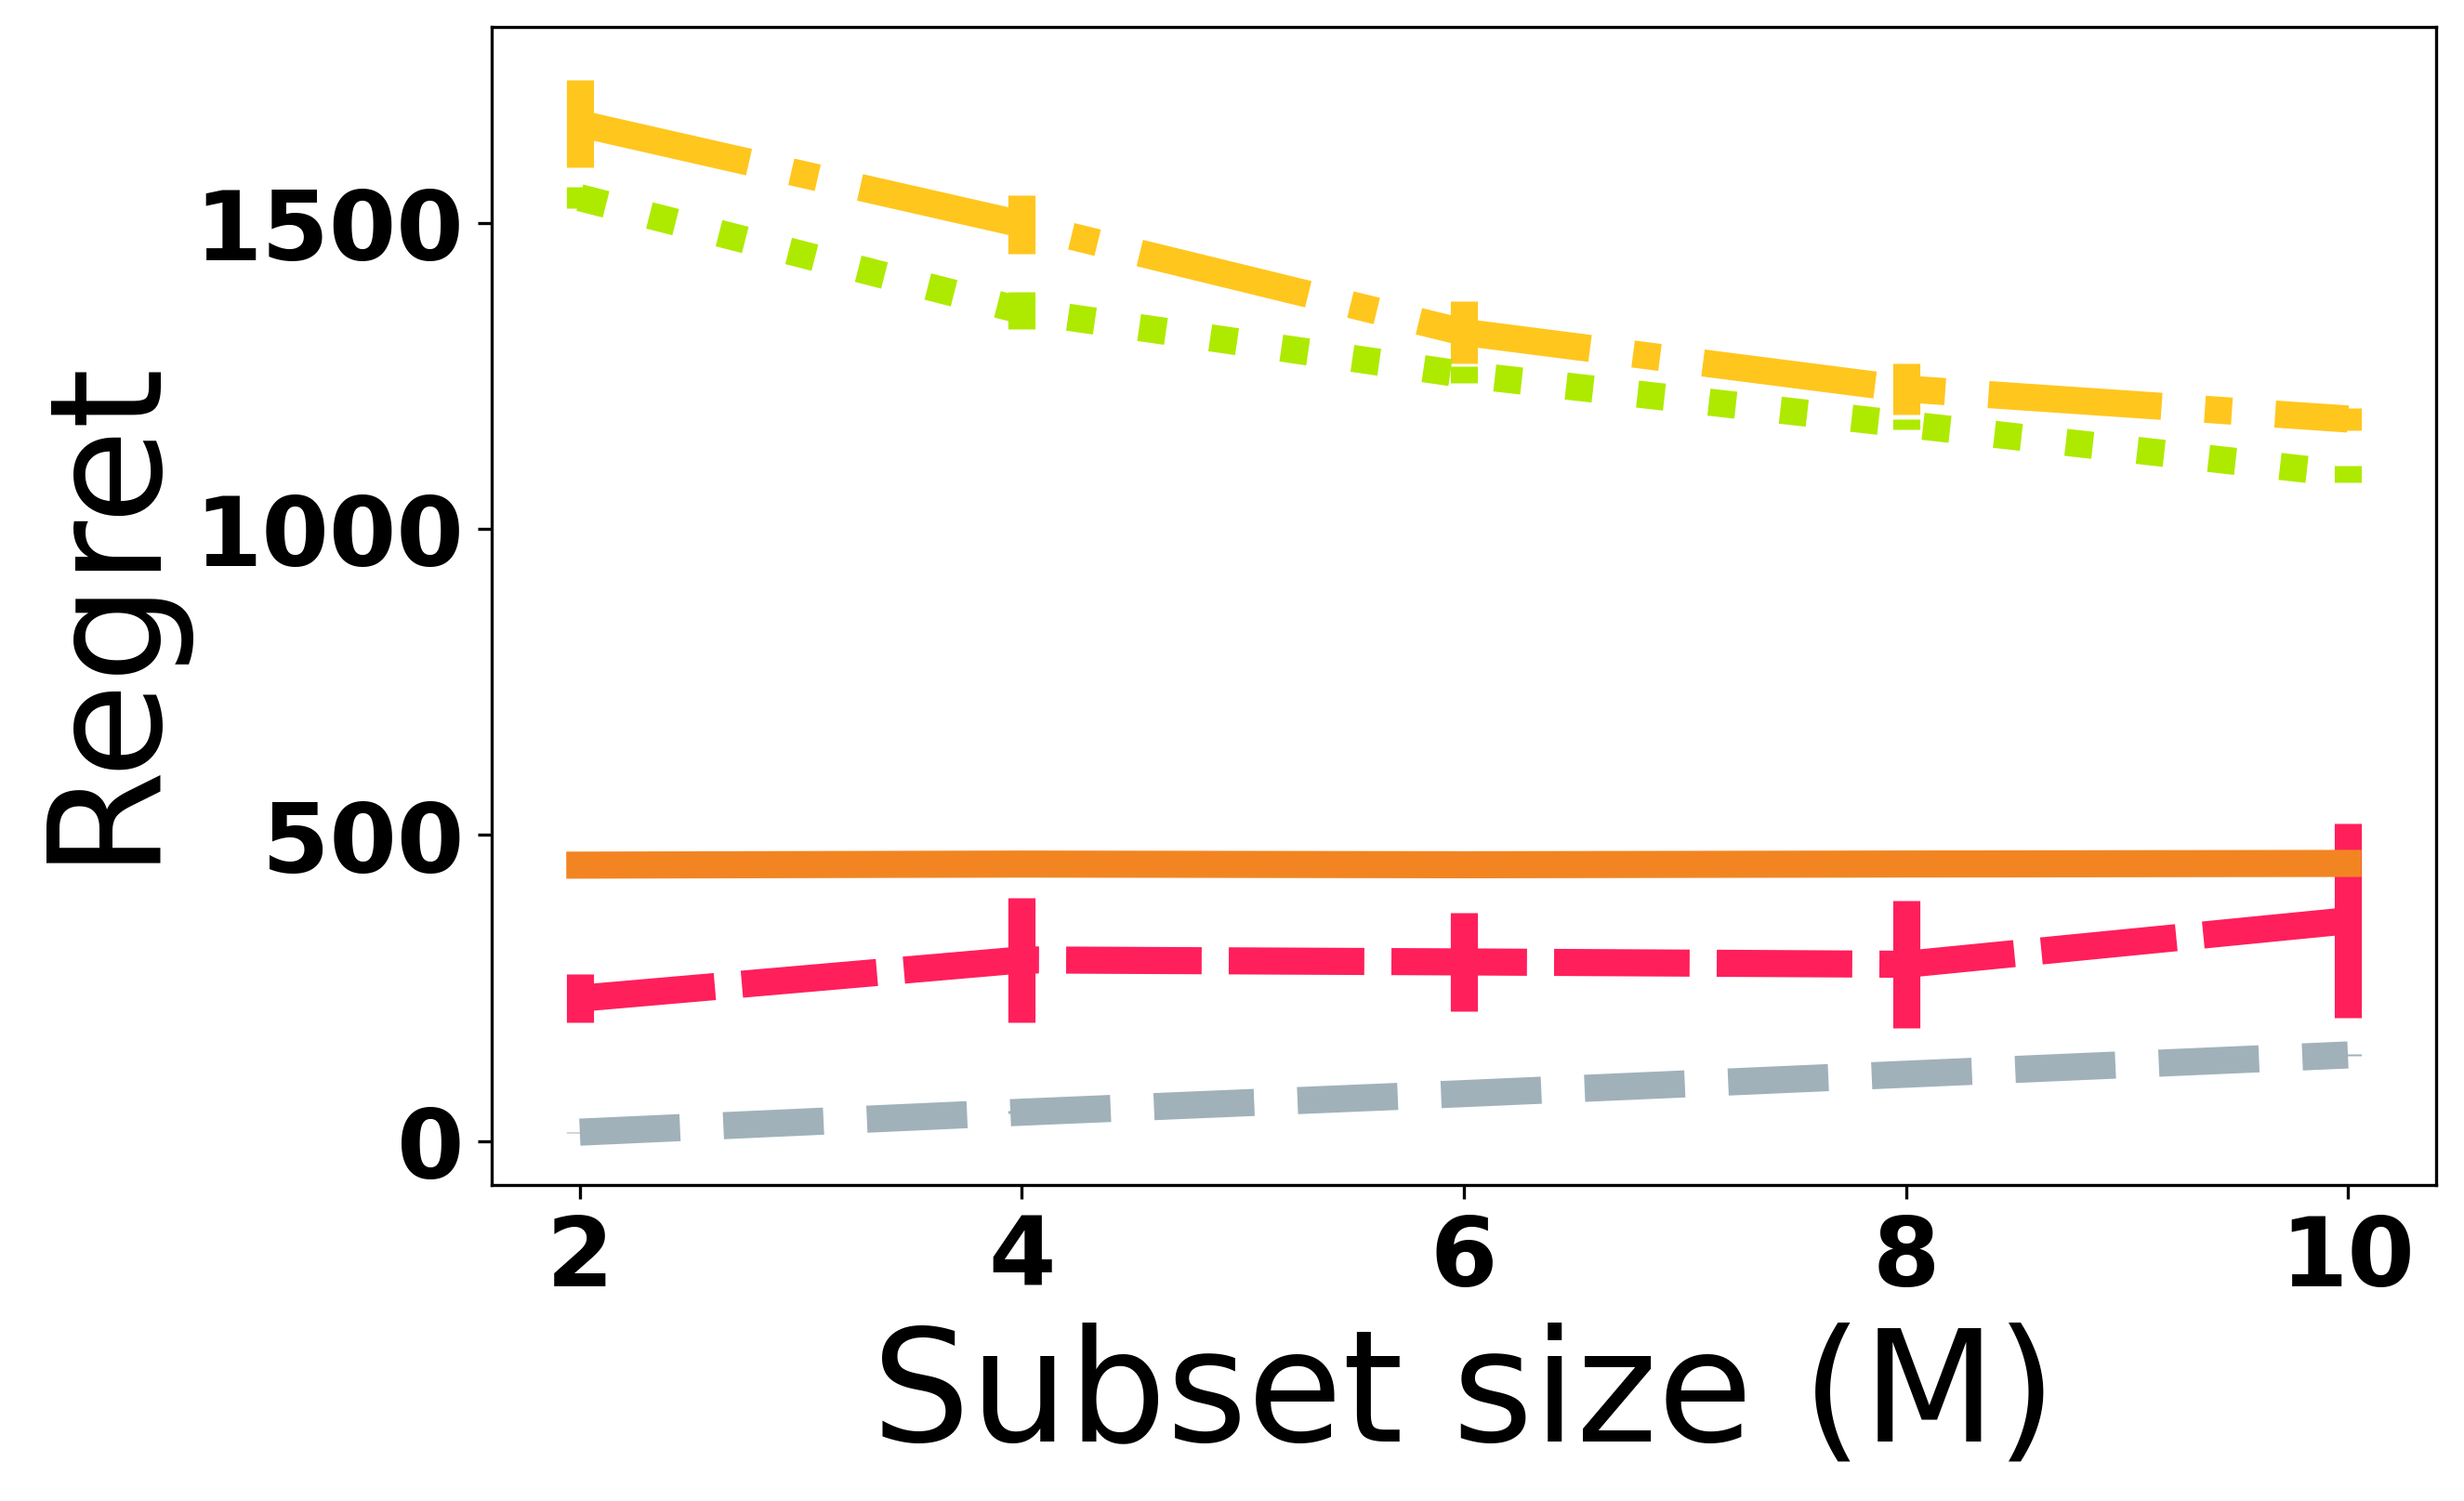

In [10]:
# Plot from loaded cache file
X_e = np.arange(2,11,2)
regret_dict_e = pickle.load(open("results/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, '', 'Subset size (M)', 'Regret', **kwargs)

# Plotting legend code

In [2]:
font = {
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]

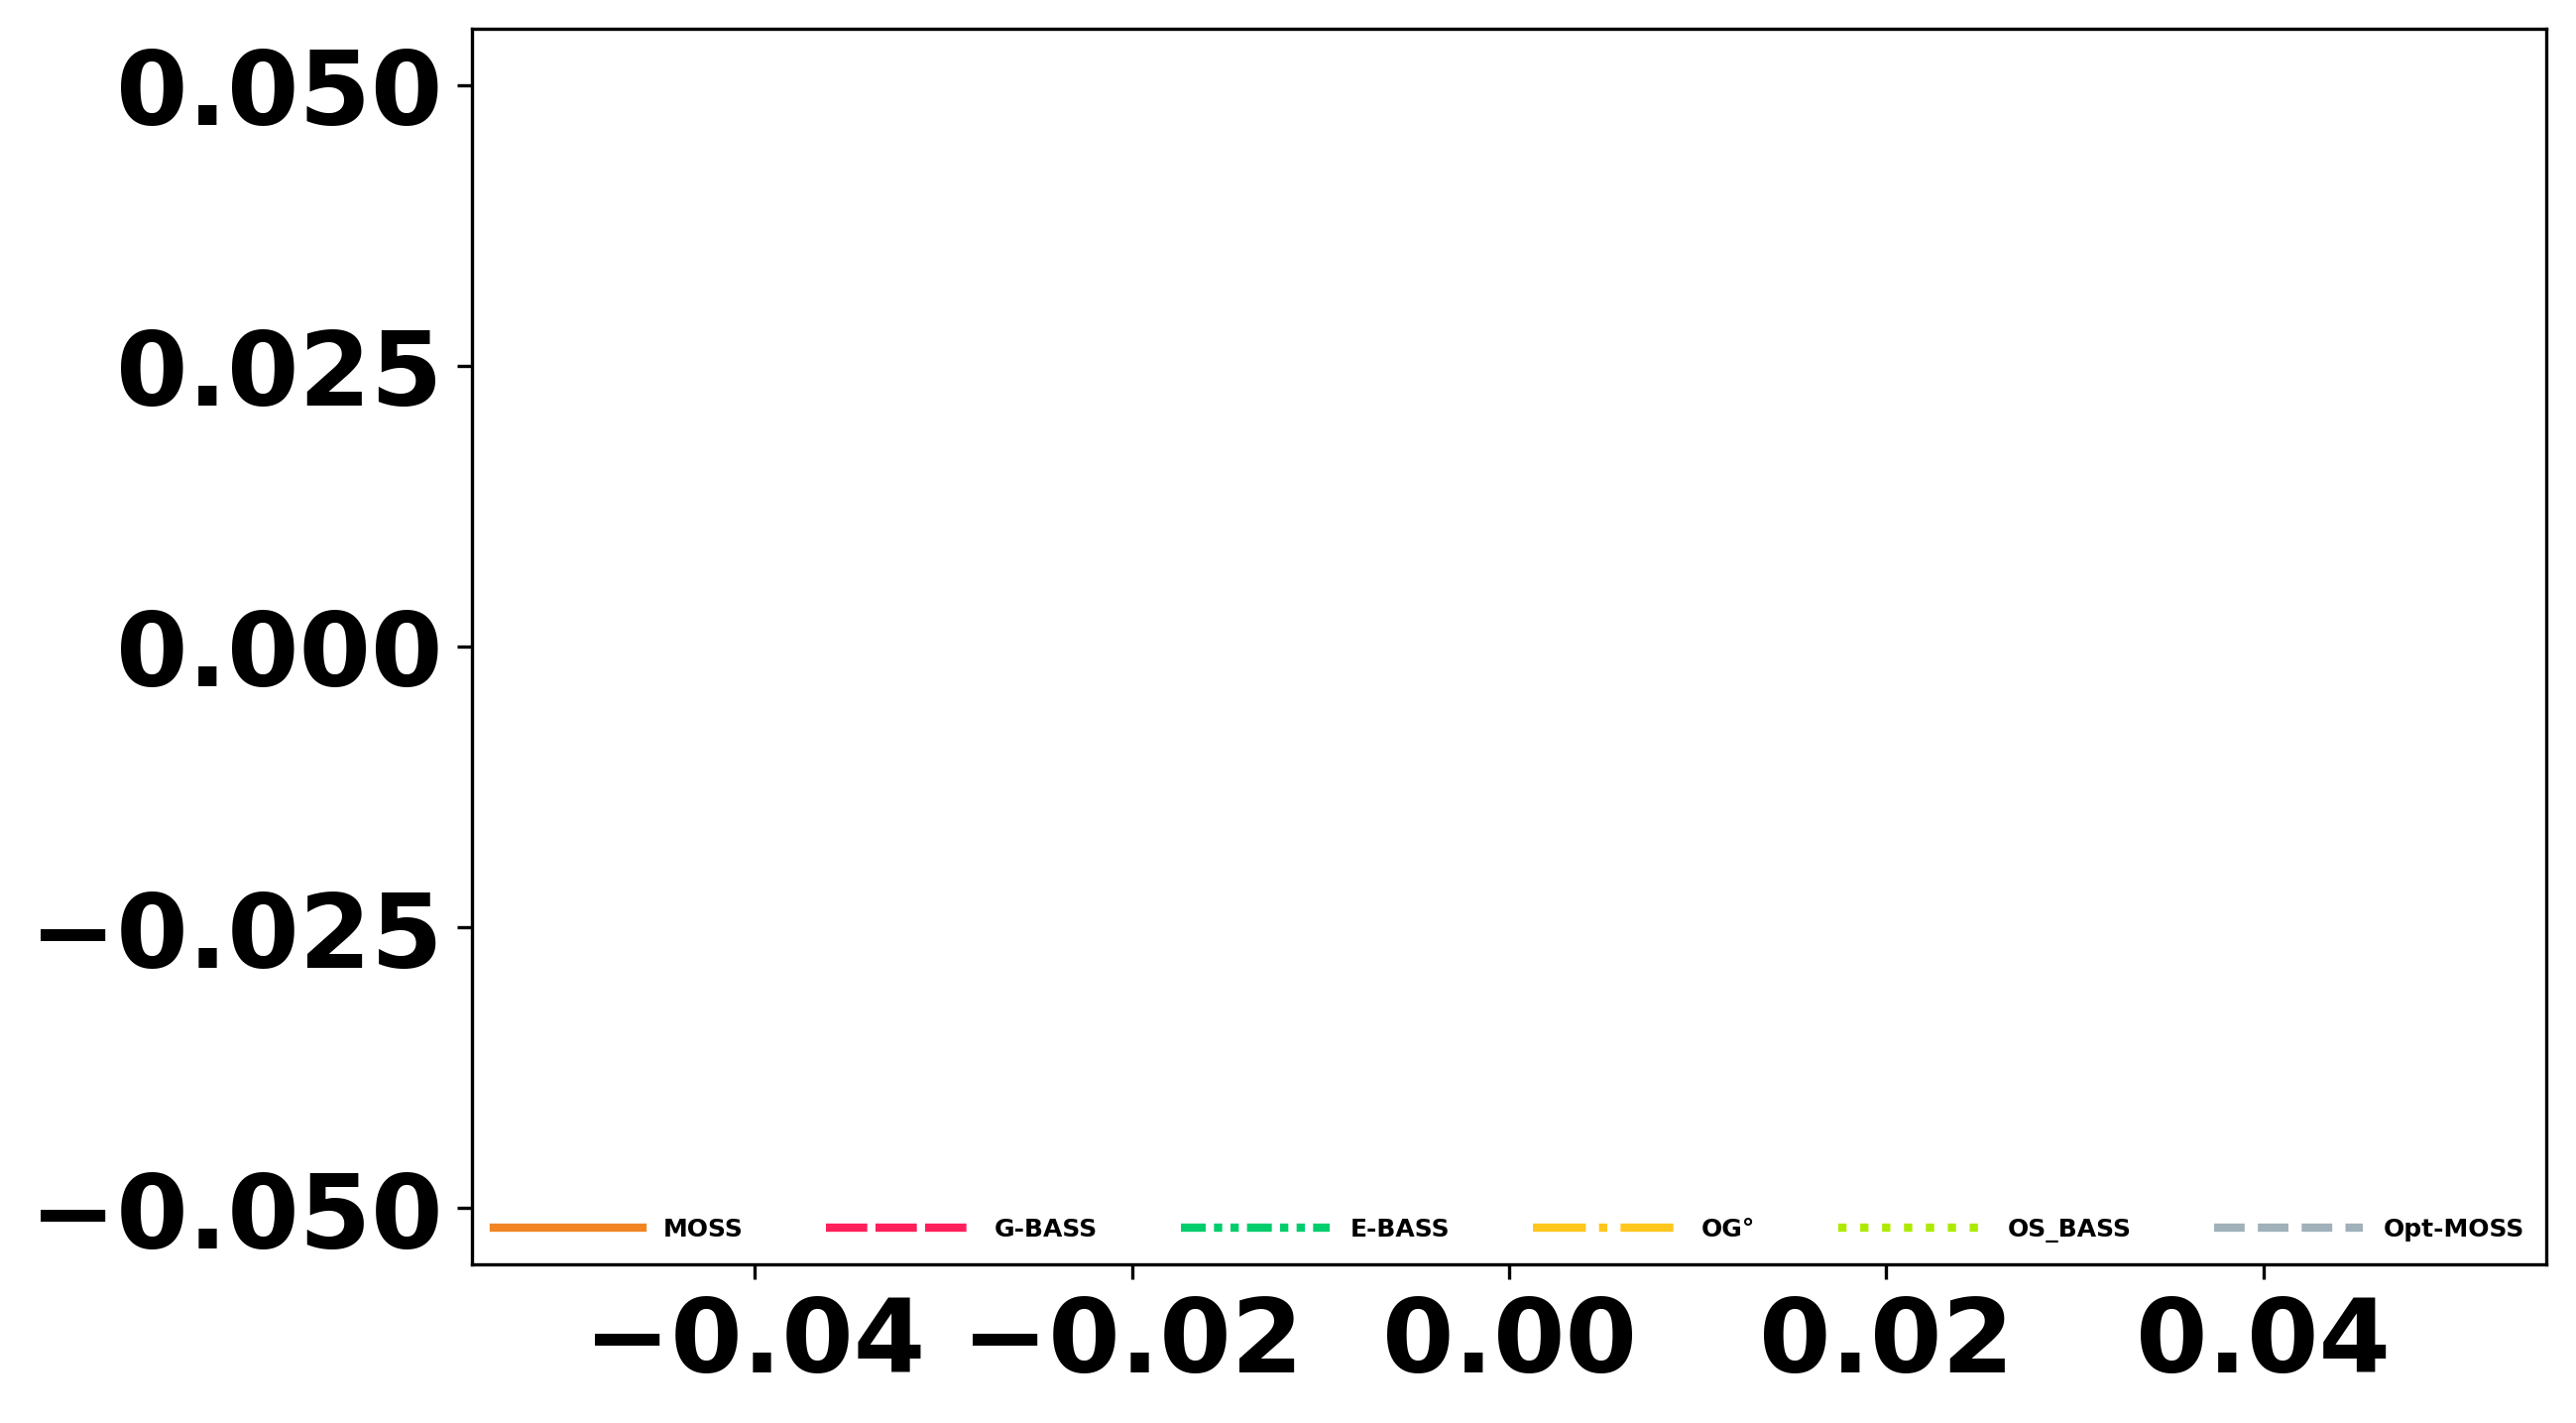

In [3]:
# # labels = ["MOSS", "G-BASS", "OG°", "OS-BASS", "Opt-MOSS"]
labels = ["MOSS", "G-BASS", "E-BASS", "OG°", "OS_BASS", "Opt-MOSS"]
# colors = ["#F28522", "#FF1F5B", "#FFC61E", "#AEEA00", "#A0B1BA"]
colors = ["#F28522", "#FF1F5B", "#00CD6C", "#FFC61E", "#AEEA00", "#A0B1BA"]
# linestyles = ["-", (0, (5, 1)), "-.", "dotted", "--" ]
linestyles = ["-", (0, (5, 1)), (0, (3,1,1,1,1, 1)), "-.", "dotted", "--"]
f = lambda c,l: plt.plot([],[], color=c, ls=l, linewidth=2)[0]
handles = [f(colors[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc='lower left', framealpha=1, frameon=False, mode="expand", 
                    ncol=6, handlelength=6)

def export_legend(legend, filename="legend6.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()